In [1]:
import warnings

# Ignore all warnings
warnings.filterwarnings("ignore")

In [2]:
import pandas as pd
import numpy as np
from math import sqrt
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style(style='dark')
from scipy.stats import zscore

from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import cross_validate
from sklearn.metrics import confusion_matrix, f1_score,recall_score,precision_recall_curve,auc,roc_curve,roc_auc_score,classification_report,accuracy_score, precision_score, make_scorer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier


import xgboost as xgb
from xgboost.sklearn import XGBClassifier

from catboost import CatBoostClassifier
import lightgbm as lgb

In [3]:
raw_df = pd.read_csv('train_clean_filled.csv')
raw_data = pd.read_csv('Train.csv')

In [4]:
test_df = pd.read_csv('test_clean_filled.csv')
test_data = pd.read_csv('Test.csv')

In [6]:
tenuremap = {
    'K > 24 month': 24,
    'I 18-21 month': (18 + 21) / 2,
    'H 15-18 month': (15 + 18) / 2,
    'G 12-15 month': (12 + 15) / 2,
    'J 21-24 month': (21 + 24) / 2,
    'F 9-12 month': (9 + 12) / 2,
    'E 6-9 month': (6 + 9) / 2,
    'D 3-6 month': (3 + 6) / 2,
}
raw_data['tenure'] = raw_data['tenure'].map(tenuremap)


In [9]:
test_data['tenure'] = test_data['tenure'].map(tenuremap)

In [11]:
raw_data.drop(columns='mrg',inplace=True)
test_data.drop(columns='mrg',inplace=True)

In [5]:
test_df.set_index('ID',inplace=True)
raw_df.set_index('ID',inplace=True)
test_data.set_index('ID',inplace=True)
raw_data.set_index('ID',inplace=True)

In [50]:
features = pd.get_dummies(raw_df.drop(columns='Target'))
targets = raw_df['Target']
rus = RandomUnderSampler(random_state=42)
X_resampled, y_resampled  = rus.fit_resample(features,targets)
print(y_resampled.value_counts())
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled , test_size=0.2, random_state=0)

0    282515
1    282515
Name: Target, dtype: int64


In [18]:
# Hyperparameter grid for XGBoost
param_grid_xgb = {
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7],
    'reg_lambda': [0.01, 0.1, 0.2],
    'reg_alpha' : [0.01, 0.1, 0.2,],
}


# Create GridSearchCV instances
grid_search_xgb = GridSearchCV(
    xgb.XGBClassifier(objective='binary:logistic', eval_metric='auc', random_state=42),
    param_grid_xgb,
    scoring='roc_auc',  
    cv=5 
)

# Fit the models
grid_search_xgb.fit(X_train, y_train)

# Get the best hyperparameters for each model
best_params_xgb = grid_search_xgb.best_params_

# Print the best hyperparameters
print("Best Hyperparameters for XGBoost:", best_params_xgb)

# Get the best models
best_model_xgb = grid_search_xgb.best_estimator_

# Evaluate the best models on the test set
y_pred_best_xgb = best_model_xgb.predict(X_test)

# Calculate metrics for the best models
accuracy_best_xgb = accuracy_score(y_test, y_pred_best_xgb)

print("Best XGBoost Accuracy:", accuracy_best_xgb)


Best Hyperparameters for XGBoost: {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 200, 'reg_alpha': 0.2, 'reg_lambda': 0.1}
Best XGBoost Accuracy: 0.890855352813125


In [19]:
model_xgb = xgb.XGBClassifier(
    learning_rate = 0.01,
    max_dephth = 3,
    n_estimators = 50,
    objective='binary:logistic',  
    eval_metric='auc',
    reg_alpha = 0.01, 
    reg_lambda = 0.01,
    random_state=0
)
model_xgb.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='auc', feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_dephth=3, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=50,
              n_jobs=None, num_parallel_tree=None, ...)

In [20]:
xgb_accuracy = cross_val_score(model_xgb, X_train, y_train, cv=5, scoring='accuracy')
xgb_f1_score = cross_val_score(model_xgb, X_train, y_train, cv=5, scoring='f1')

print("XGBoost Cross-Validation Results:")
print("Accuracy:", xgb_accuracy.mean())
print("F1 Score:", xgb_f1_score.mean())

XGBoost Cross-Validation Results:
Accuracy: 0.8851122946852238
F1 Score: 0.8905166858517021


Accuracy: 0.8857848255844822
Confusion Matrix:
[[46968  9335]
 [ 3572 53131]]
___________________________
F1 Score: 0.8916916312128155
Feature ranking:
regularity: 0.5351529717445374
region_Mandalore: 0.19077880680561066
zone2: 0.09775912016630173
Null_Count: 0.0708824098110199
Amount: 0.03798815980553627
Procuct_2: 0.02248508296906948
region_Quasar: 0.018273403868079185
zone1: 0.007366953417658806
data_volume: 0.004837729502469301
region_Zodiacalia: 0.0025008160155266523
freq_top_pack: 0.0022949189879000187
Procuct_1: 0.0022594882175326347
arpu_segment: 0.001977586420252919
refill_frequency: 0.0017985121812671423
on_net: 0.00137603422626853
region_Nebula: 0.0010108646238222718
revenue: 0.0007402250193990767
frequency: 0.0005169234937056899
region_Radiantara: 0.0
region_Nebulith: 0.0
region_Eclipsara: 0.0
region_Droidika: 0.0
region_Luminous: 0.0
region_Forcehaven: 0.0
region_Eternum: 0.0
region_Stellaris: 0.0
region_Astral: 0.0
region_Celestial: 0.0
tenure: 0.0


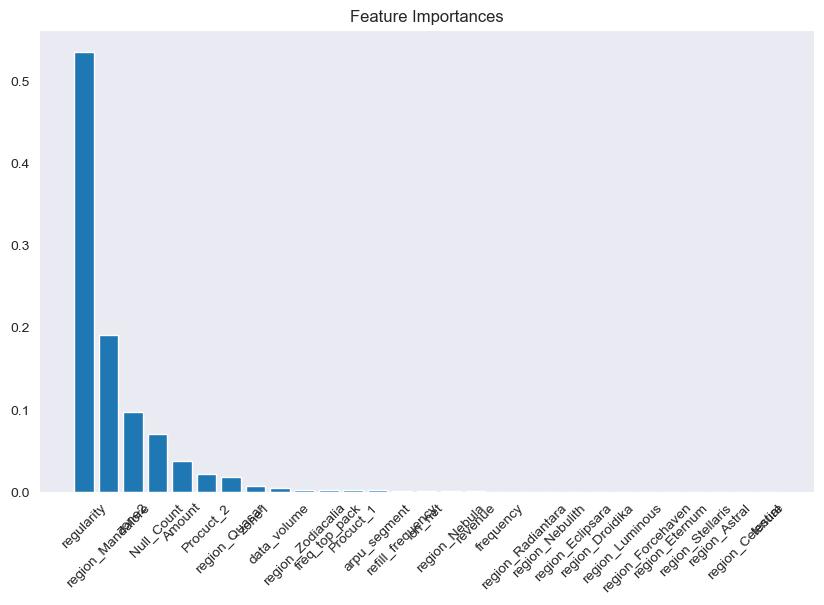

In [21]:
y_pred = model_xgb.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)
print('___________________________')
f1 = f1_score(y_test, y_pred)
print("F1 Score:", f1)
importances = model_xgb.feature_importances_
indices = np.argsort(importances)[::-1]
print("Feature ranking:")
for f in range(X_train.shape[1]):
    print(f"{X_train.columns[indices[f]]}: {importances[indices[f]]}")
plt.figure(figsize=(10, 6))
plt.bar(range(X_train.shape[1]), importances[indices], align="center")
plt.xticks(range(X_train.shape[1]), X_train.columns[indices], rotation=45)
plt.title("Feature Importances")
plt.show()

In [22]:
precision_xgb = precision_score(y_test, y_pred)
recall_xgb = recall_score(y_test, y_pred)
f1_xgb = f1_score(y_test, y_pred)
auc_roc_xgb = roc_auc_score(y_test, model_xgb.predict_proba(X_test)[:, 1])
print("XGBoost Metrics:")
print(f"Precision: {precision_xgb:.4f}")
print(f"Recall: {recall_xgb:.4f}")
print(f"F1 Score: {f1_xgb:.4f}")
print(f"AUC-ROC: {auc_roc_xgb:.4f}\n")
print('________________________________________________________')

XGBoost Metrics:
Precision: 0.8506
Recall: 0.9370
F1 Score: 0.8917
AUC-ROC: 0.9432

________________________________________________________


In [24]:
model_xgb2 = xgb.XGBClassifier(
    learning_rate = 0.1,
    max_dephth = 7,
    n_estimators = 200,
    objective='binary:logistic',  
    eval_metric='auc',
    reg_alpha = 0.02, 
    reg_lambda = 0.01,
    random_state=0
)
model_xgb2.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='auc', feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_dephth=7, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=200,
              n_jobs=None, num_parallel_tree=None, ...)

In [25]:
xgb_accuracy2 = cross_val_score(model_xgb2, X_train, y_train, cv=5, scoring='accuracy')
xgb_f1_score2 = cross_val_score(model_xgb2, X_train, y_train, cv=5, scoring='f1')

print("XGBoost Cross-Validation Results:")
print("Accuracy:", xgb_accuracy2.mean())
print("F1 Score:", xgb_f1_score2.mean())

XGBoost Cross-Validation Results:
Accuracy: 0.8904239601595583
F1 Score: 0.8969588945939495


Accuracy: 0.8907491637612163
Confusion Matrix:
[[46468  9835]
 [ 2511 54192]]
___________________________
F1 Score: 0.8977387559015986
Feature ranking:
regularity: 0.5351529717445374
region_Mandalore: 0.19077880680561066
zone2: 0.09775912016630173
Null_Count: 0.0708824098110199
Amount: 0.03798815980553627
Procuct_2: 0.02248508296906948
region_Quasar: 0.018273403868079185
zone1: 0.007366953417658806
data_volume: 0.004837729502469301
region_Zodiacalia: 0.0025008160155266523
freq_top_pack: 0.0022949189879000187
Procuct_1: 0.0022594882175326347
arpu_segment: 0.001977586420252919
refill_frequency: 0.0017985121812671423
on_net: 0.00137603422626853
region_Nebula: 0.0010108646238222718
revenue: 0.0007402250193990767
frequency: 0.0005169234937056899
region_Radiantara: 0.0
region_Nebulith: 0.0
region_Eclipsara: 0.0
region_Droidika: 0.0
region_Luminous: 0.0
region_Forcehaven: 0.0
region_Eternum: 0.0
region_Stellaris: 0.0
region_Astral: 0.0
region_Celestial: 0.0
tenure: 0.0


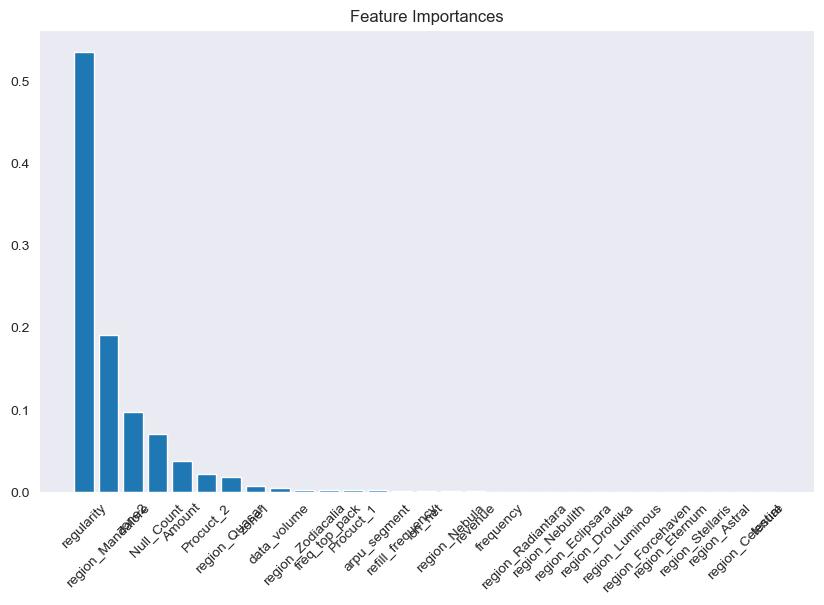

In [26]:
y_pred = model_xgb2.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)
print('___________________________')
f1 = f1_score(y_test, y_pred)
print("F1 Score:", f1)
importances = model_xgb.feature_importances_
indices = np.argsort(importances)[::-1]
print("Feature ranking:")
for f in range(X_train.shape[1]):
    print(f"{X_train.columns[indices[f]]}: {importances[indices[f]]}")
plt.figure(figsize=(10, 6))
plt.bar(range(X_train.shape[1]), importances[indices], align="center")
plt.xticks(range(X_train.shape[1]), X_train.columns[indices], rotation=45)
plt.title("Feature Importances")
plt.show()

In [27]:
precision_xgb = precision_score(y_test, y_pred)
recall_xgb = recall_score(y_test, y_pred)
f1_xgb = f1_score(y_test, y_pred)
auc_roc_xgb = roc_auc_score(y_test, model_xgb2.predict_proba(X_test)[:, 1])
print("XGBoost Metrics:")
print(f"Precision: {precision_xgb:.4f}")
print(f"Recall: {recall_xgb:.4f}")
print(f"F1 Score: {f1_xgb:.4f}")
print(f"AUC-ROC: {auc_roc_xgb:.4f}\n")
print('________________________________________________________')

XGBoost Metrics:
Precision: 0.8464
Recall: 0.9557
F1 Score: 0.8977
AUC-ROC: 0.9471

________________________________________________________


In [56]:
test_df = pd.get_dummies(test_df)
test_df

,tenure,Amount,refill_frequency,revenue,arpu_segment,frequency,data_volume,on_net,Procuct_1,Procuct_2,...,region_Eternum,region_Forcehaven,region_Luminous,region_Mandalore,region_Nebula,region_Nebulith,region_Quasar,region_Radiantara,region_Stellaris,region_Zodiacalia
ID,,,,,,,,,,,,,,,,,,,,,
ID_LZ8K373W7EWV,24.0,2008.550,16.0,2010.26,670.09,17.0,10.0,247.0,17.0,70.0,...,0,0,0,0,0,0,0,0,0,0
ID_04KNWHGV5783,24.0,2991.450,14.0,2991.45,997.01,17.0,807.5,99.0,100.0,84.0,...,0,0,1,0,0,0,0,0,0,0
ID_CXS07G6VLB2U,24.0,1581.200,8.0,1578.21,526.07,8.0,436.0,47.0,113.0,5.0,...,0,0,0,0,0,0,0,0,0,0
ID_N3NFJJVHS25K,24.0,2564.100,12.0,2777.78,926.07,13.0,0.0,135.0,181.0,4.0,...,0,0,0,0,0,0,0,0,0,0
ID_R36J4ROT93E9,24.0,1391.025,7.0,1343.16,447.86,9.0,309.0,26.0,31.0,7.0,...,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ID_MGZSA4ICBD9O,24.0,4273.500,19.0,4487.18,1495.73,20.0,60.0,60.0,208.0,80.0,...,0,0,0,0,0,0,0,0,1,0
ID_XGDT520DFBLP,24.0,6901.710,41.0,7115.38,2371.79,41.0,7019.0,105.0,257.0,5.0,...,0,0,0,1,0,0,0,0,0,0
ID_9RDB792PB5Q4,24.0,2008.550,9.0,42.31,14.10,1.0,0.0,1.0,1.0,7.0,...,0,0,0,1,0,0,0,0,0,0


In [32]:
final_pred = model_xgb.predict(test_df)
final_pred
data = list(zip(test_df.index, final_pred))

result_df = pd.DataFrame(data, columns=['ID', 'Predictions'])
print(result_df)
print(result_df['Predictions'].value_counts())
result_df.to_csv('Submission4.1.1.csv',index=False)

                     ID  Predictions
0       ID_LZ8K373W7EWV            0
1       ID_04KNWHGV5783            0
2       ID_CXS07G6VLB2U            0
3       ID_N3NFJJVHS25K            0
4       ID_R36J4ROT93E9            1
...                 ...          ...
380122  ID_MGZSA4ICBD9O            0
380123  ID_XGDT520DFBLP            0
380124  ID_9RDB792PB5Q4            0
380125  ID_KDTJHH8L8Z13            0
380126  ID_2F6Y446GS8T3            1

[380127 rows x 2 columns]
0    266017
1    114110
Name: Predictions, dtype: int64


In [33]:
final_pred = model_xgb2.predict(test_df)
final_pred
data = list(zip(test_df.index, final_pred))

result_df = pd.DataFrame(data, columns=['ID', 'Predictions'])
print(result_df)
print(result_df['Predictions'].value_counts())
result_df.to_csv('Submission4.1.2.csv',index=False)

                     ID  Predictions
0       ID_LZ8K373W7EWV            0
1       ID_04KNWHGV5783            0
2       ID_CXS07G6VLB2U            0
3       ID_N3NFJJVHS25K            0
4       ID_R36J4ROT93E9            1
...                 ...          ...
380122  ID_MGZSA4ICBD9O            0
380123  ID_XGDT520DFBLP            0
380124  ID_9RDB792PB5Q4            0
380125  ID_KDTJHH8L8Z13            0
380126  ID_2F6Y446GS8T3            1

[380127 rows x 2 columns]
0    262332
1    117795
Name: Predictions, dtype: int64


In [34]:
raw_df

,region,tenure,Amount,refill_frequency,revenue,arpu_segment,frequency,data_volume,on_net,Procuct_1,Procuct_2,zone1,zone2,regularity,freq_top_pack,Target,Null_Count
ID,,,,,,,,,,,,,,,,,
ID_YEB05X4KUGPQ,Mandalore,24.0,1346.15,7.0,1302.56,434.19,9.0,301.0,26.0,31.0,7.0,1.0,1.0,3,5.0,0,14
ID_Z9IQ9QH52KVN,Nebula,24.0,4764.96,41.0,4756.84,1585.47,41.0,2.0,626.0,24.0,3.0,1.0,1.0,62,31.0,0,3
ID_YZSU7B7M35QS,Celestial,24.0,5769.23,22.0,5769.23,1923.08,22.0,28121.0,0.0,31.0,1.0,1.0,1.0,61,4.0,0,5
ID_QS4F5LEX29KM,Mandalore,24.0,1346.15,7.0,1302.56,434.19,9.0,301.0,26.0,31.0,7.0,1.0,1.0,6,5.0,0,14
ID_8IYIC9PFU8U1,Eclipsara,24.0,5341.88,58.0,5636.75,1879.06,60.0,1131.0,546.0,376.0,0.0,1.0,1.0,62,31.0,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ID_D1MA2025F1U6,Mandalore,24.0,7179.49,17.0,6972.22,2323.93,18.0,4269.0,7.0,31.0,11.0,0.0,61.0,41,4.0,0,2
ID_9H6BGU1FS1CD,Celestial,24.0,854.70,2.0,854.70,285.04,2.0,2276.0,0.0,31.0,7.0,1.0,1.0,36,2.0,0,4
ID_QWJPIJ065LA4,Luminous,24.0,1923.08,9.0,2136.75,712.39,10.0,790.0,34.0,74.0,48.0,1.0,1.0,40,10.0,0,3


In [35]:

param_grid_rf = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
}


# Create GridSearchCV instances
grid_search_rf = GridSearchCV(
    RandomForestClassifier(random_state=0),
    param_grid_rf,
    scoring='roc_auc', 
    cv=10  
)

grid_search_rf.fit(X_train, y_train)
best_params_rf = grid_search_rf.best_params_
print("Best Hyperparameters for RandomForest:", best_params_rf)
best_model_rf = grid_search_rf.best_estimator_
y_pred_best_rf = best_model_rf.predict(X_test)
accuracy_best_rf = accuracy_score(y_test, y_pred_best_rf)
print("Best RandomForest Accuracy:", accuracy_best_rf)


KeyboardInterrupt: 

In [13]:
raw_df

,region,tenure,Amount,refill_frequency,revenue,arpu_segment,frequency,data_volume,on_net,Procuct_1,Procuct_2,zone1,zone2,regularity,freq_top_pack,Target,Null_Count
ID,,,,,,,,,,,,,,,,,
ID_YEB05X4KUGPQ,Mandalore,24.0,1346.15,7.0,1302.56,434.19,9.0,301.0,26.0,31.0,7.0,1.0,1.0,3,5.0,0,14
ID_Z9IQ9QH52KVN,Nebula,24.0,4764.96,41.0,4756.84,1585.47,41.0,2.0,626.0,24.0,3.0,1.0,1.0,62,31.0,0,3
ID_YZSU7B7M35QS,Celestial,24.0,5769.23,22.0,5769.23,1923.08,22.0,28121.0,0.0,31.0,1.0,1.0,1.0,61,4.0,0,5
ID_QS4F5LEX29KM,Mandalore,24.0,1346.15,7.0,1302.56,434.19,9.0,301.0,26.0,31.0,7.0,1.0,1.0,6,5.0,0,14
ID_8IYIC9PFU8U1,Eclipsara,24.0,5341.88,58.0,5636.75,1879.06,60.0,1131.0,546.0,376.0,0.0,1.0,1.0,62,31.0,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ID_D1MA2025F1U6,Mandalore,24.0,7179.49,17.0,6972.22,2323.93,18.0,4269.0,7.0,31.0,11.0,0.0,61.0,41,4.0,0,2
ID_9H6BGU1FS1CD,Celestial,24.0,854.70,2.0,854.70,285.04,2.0,2276.0,0.0,31.0,7.0,1.0,1.0,36,2.0,0,4
ID_QWJPIJ065LA4,Luminous,24.0,1923.08,9.0,2136.75,712.39,10.0,790.0,34.0,74.0,48.0,1.0,1.0,40,10.0,0,3


In [18]:
scaled_features = np.log(raw_df.drop(columns=['region','Target','Null_Count','tenure'])+1)
scaled_features = pd.concat([scaled_features, raw_df[['region', 'Target', 'Null_Count', 'tenure']]], axis=1)
scaled_features

,Amount,refill_frequency,revenue,arpu_segment,frequency,data_volume,on_net,Procuct_1,Procuct_2,zone1,zone2,regularity,freq_top_pack,region,Target,Null_Count,tenure
ID,,,,,,,,,,,,,,,,,
ID_YEB05X4KUGPQ,7.205747,2.079442,7.172854,6.075783,2.302585,5.710427,3.295837,3.465736,2.079442,0.693147,0.693147,1.386294,1.791759,Mandalore,0,14,24.0
ID_Z9IQ9QH52KVN,8.469254,3.737670,8.467549,7.369267,3.737670,1.098612,6.440947,3.218876,1.386294,0.693147,0.693147,4.143135,3.465736,Nebula,0,3,24.0
ID_YZSU7B7M35QS,8.660467,3.135494,8.660467,7.562203,3.135494,10.244307,0.000000,3.465736,0.693147,0.693147,0.693147,4.127134,1.609438,Celestial,0,5,24.0
ID_QS4F5LEX29KM,7.205747,2.079442,7.172854,6.075783,2.302585,5.710427,3.295837,3.465736,2.079442,0.693147,0.693147,1.945910,1.791759,Mandalore,0,14,24.0
ID_8IYIC9PFU8U1,8.583520,4.077537,8.637240,7.539059,4.110874,7.031741,6.304449,5.932245,0.000000,0.693147,0.693147,4.143135,3.465736,Eclipsara,0,2,24.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ID_D1MA2025F1U6,8.879123,2.890372,8.849832,7.751445,2.944439,8.359369,2.079442,3.465736,2.484907,0.000000,4.127134,3.737670,1.609438,Mandalore,0,2,24.0
ID_9H6BGU1FS1CD,6.751920,1.098612,6.751920,5.656132,1.098612,7.730614,0.000000,3.465736,2.079442,0.693147,0.693147,3.610918,1.098612,Celestial,0,4,24.0
ID_QWJPIJ065LA4,7.562203,2.302585,7.667509,6.570028,2.397895,6.673298,3.555348,4.317488,3.891820,0.693147,0.693147,3.713572,2.397895,Luminous,0,3,24.0


In [26]:
test_df

,region,tenure,Amount,refill_frequency,revenue,arpu_segment,frequency,data_volume,on_net,Procuct_1,Procuct_2,zone1,zone2,regularity,freq_top_pack,Null_Count
ID,,,,,,,,,,,,,,,,
ID_LZ8K373W7EWV,Droidika,24.0,2008.550,16.0,2010.26,670.09,17.0,10.0,247.0,17.0,70.0,1.0,1.0,59,11.0,2
ID_04KNWHGV5783,Luminous,24.0,2991.450,14.0,2991.45,997.01,17.0,807.5,99.0,100.0,84.0,1.0,1.0,49,12.0,3
ID_CXS07G6VLB2U,Astral,24.0,1581.200,8.0,1578.21,526.07,8.0,436.0,47.0,113.0,5.0,1.0,1.0,13,6.0,2
ID_N3NFJJVHS25K,Eclipsara,24.0,2564.100,12.0,2777.78,926.07,13.0,0.0,135.0,181.0,4.0,1.0,1.0,53,13.0,3
ID_R36J4ROT93E9,Mandalore,24.0,1391.025,7.0,1343.16,447.86,9.0,309.0,26.0,31.0,7.0,1.0,1.0,1,5.0,14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ID_MGZSA4ICBD9O,Stellaris,24.0,4273.500,19.0,4487.18,1495.73,20.0,60.0,60.0,208.0,80.0,1.0,1.0,54,20.0,3
ID_XGDT520DFBLP,Mandalore,24.0,6901.710,41.0,7115.38,2371.79,41.0,7019.0,105.0,257.0,5.0,1.0,1.0,59,33.0,3
ID_9RDB792PB5Q4,Mandalore,24.0,2008.550,9.0,42.31,14.10,1.0,0.0,1.0,1.0,7.0,1.0,2.0,43,6.0,7


In [27]:
scaled_test = np.log(test_df.drop(columns=['region', 'Null_Count','tenure'])+1)
scaled_test = pd.concat([scaled_test, test_df[['region', 'Null_Count', 'tenure']]], axis=1)
scaled_test

,Amount,refill_frequency,revenue,arpu_segment,frequency,data_volume,on_net,Procuct_1,Procuct_2,zone1,zone2,regularity,freq_top_pack,region,Null_Count,tenure
ID,,,,,,,,,,,,,,,,
ID_LZ8K373W7EWV,7.605666,2.833213,7.606517,6.508903,2.890372,2.397895,5.513429,2.890372,4.262680,0.693147,0.693147,4.094345,2.484907,Droidika,2,24.0
ID_04KNWHGV5783,8.003848,2.708050,8.003848,6.905763,2.890372,6.695181,4.605170,4.615121,4.442651,0.693147,0.693147,3.912023,2.564949,Luminous,3,24.0
ID_CXS07G6VLB2U,7.366572,2.197225,7.364680,6.267333,2.197225,6.079933,3.871201,4.736198,1.791759,0.693147,0.693147,2.639057,1.945910,Astral,2,24.0
ID_N3NFJJVHS25K,7.849753,2.564949,7.929767,6.832029,2.639057,0.000000,4.912655,5.204007,1.609438,0.693147,0.693147,3.988984,2.639057,Eclipsara,3,24.0
ID_R36J4ROT93E9,7.238515,2.079442,7.203525,6.106711,2.302585,5.736572,3.295837,3.465736,2.079442,0.693147,0.693147,0.693147,1.791759,Mandalore,14,24.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ID_MGZSA4ICBD9O,8.360422,2.995732,8.409203,7.311038,3.044522,4.110874,4.110874,5.342334,4.394449,0.693147,0.693147,4.007333,3.044522,Stellaris,3,24.0
ID_XGDT520DFBLP,8.839669,3.737670,8.870154,7.771822,3.737670,8.856518,4.663439,5.552960,1.791759,0.693147,0.693147,4.094345,3.526361,Mandalore,3,24.0
ID_9RDB792PB5Q4,7.605666,2.302585,3.768384,2.714695,0.693147,0.000000,0.693147,0.693147,2.079442,0.693147,1.098612,3.784190,1.945910,Mandalore,7,24.0


In [31]:
scaled_test = pd.get_dummies(scaled_test)
scaled_test

,Amount,refill_frequency,revenue,arpu_segment,frequency,data_volume,on_net,Procuct_1,Procuct_2,zone1,...,region_Eternum,region_Forcehaven,region_Luminous,region_Mandalore,region_Nebula,region_Nebulith,region_Quasar,region_Radiantara,region_Stellaris,region_Zodiacalia
ID,,,,,,,,,,,,,,,,,,,,,
ID_LZ8K373W7EWV,7.605666,2.833213,7.606517,6.508903,2.890372,2.397895,5.513429,2.890372,4.262680,0.693147,...,0,0,0,0,0,0,0,0,0,0
ID_04KNWHGV5783,8.003848,2.708050,8.003848,6.905763,2.890372,6.695181,4.605170,4.615121,4.442651,0.693147,...,0,0,1,0,0,0,0,0,0,0
ID_CXS07G6VLB2U,7.366572,2.197225,7.364680,6.267333,2.197225,6.079933,3.871201,4.736198,1.791759,0.693147,...,0,0,0,0,0,0,0,0,0,0
ID_N3NFJJVHS25K,7.849753,2.564949,7.929767,6.832029,2.639057,0.000000,4.912655,5.204007,1.609438,0.693147,...,0,0,0,0,0,0,0,0,0,0
ID_R36J4ROT93E9,7.238515,2.079442,7.203525,6.106711,2.302585,5.736572,3.295837,3.465736,2.079442,0.693147,...,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ID_MGZSA4ICBD9O,8.360422,2.995732,8.409203,7.311038,3.044522,4.110874,4.110874,5.342334,4.394449,0.693147,...,0,0,0,0,0,0,0,0,1,0
ID_XGDT520DFBLP,8.839669,3.737670,8.870154,7.771822,3.737670,8.856518,4.663439,5.552960,1.791759,0.693147,...,0,0,0,1,0,0,0,0,0,0
ID_9RDB792PB5Q4,7.605666,2.302585,3.768384,2.714695,0.693147,0.000000,0.693147,0.693147,2.079442,0.693147,...,0,0,0,1,0,0,0,0,0,0


In [19]:
features = pd.get_dummies(scaled_features.drop(columns='Target'))
targets = raw_df['Target']

rus = RandomUnderSampler(random_state=42)
X_resampled, y_resampled  = rus.fit_resample(features,targets)
print(y_resampled.value_counts())
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled , test_size=0.2, random_state=0)

0    282515
1    282515
Name: Target, dtype: int64


Random Forest Cross-Validation Results:
Accuracy: 0.8874993406511947
F1 Score: 0.8932965768377056

Accuracy: 0.8873599631877953
Confusion Matrix:
[[46798  9505]
 [ 3224 53479]]
___________________________
F1 Score: 0.893647597483436
Feature ranking:
regularity: 0.20854623402676647
Null_Count: 0.16442427710986196
revenue: 0.08342982400080057
arpu_segment: 0.06627626797702289
region_Mandalore: 0.06504456970604745
frequency: 0.06415822762549657
Amount: 0.05692101125773794
zone2: 0.05510923926542409
on_net: 0.04708024772746598
Procuct_1: 0.04317029637628618
data_volume: 0.03868832172504125
freq_top_pack: 0.03733234763683234
refill_frequency: 0.03073306874945837
Procuct_2: 0.018913514967584845
zone1: 0.005622344147030955
region_Droidika: 0.00422207614498535
tenure: 0.002964943389061969
region_Stellaris: 0.0015846717694247491
region_Eclipsara: 0.0015248384823170274
region_Luminous: 0.0012424983680400536
region_Quasar: 0.0009616390626426779
region_Celestial: 0.0007437068498971053
region_Nebul

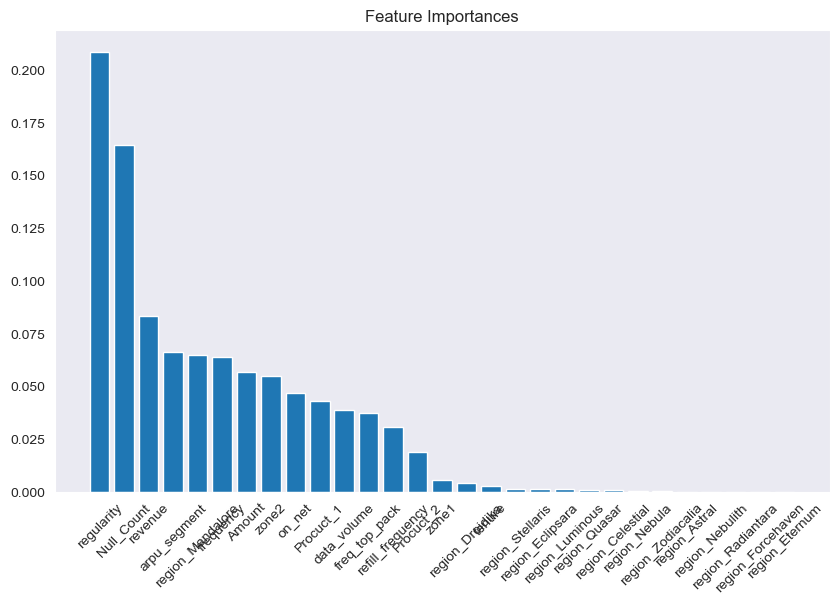

In [20]:
model_rf = RandomForestClassifier(max_depth=None, min_samples_leaf= 1, min_samples_split= 10, n_estimators= 100, random_state=0)
model_rf.fit(X_train,y_train)
scoring = {'accuracy': make_scorer(accuracy_score), 'f1_score': make_scorer(f1_score)}

# Initialize cross-validation strategy
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Cross-validate Random Forest
rf_accuracy = cross_val_score(model_rf, X_train, y_train, cv=cv, scoring='accuracy')
rf_f1_score = cross_val_score(model_rf, X_train, y_train, cv=cv, scoring='f1')

print("Random Forest Cross-Validation Results:")
print("Accuracy:", rf_accuracy.mean())
print("F1 Score:", rf_f1_score.mean())
print()
y_pred = model_rf.predict(X_test)

accuracy = accuracy_score(y_test,y_pred)
print("Accuracy:", accuracy)
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)
print('___________________________')
f1 = f1_score(y_test, y_pred)
print("F1 Score:", f1)

# Access feature importances
importances = model_rf.feature_importances_

# Get the indices that would sort the importances in descending order
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")
for f in range(X_train.shape[1]):
    print(f"{X_train.columns[indices[f]]}: {importances[indices[f]]}")

# Optionally, plot the feature importances
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.bar(range(X_train.shape[1]), importances[indices], align="center")
plt.xticks(range(X_train.shape[1]), X_train.columns[indices], rotation=45)
plt.title("Feature Importances")
plt.show()


In [21]:
precision_rf = precision_score(y_test, y_pred)
recall_rf = recall_score(y_test, y_pred)
f1_rf = f1_score(y_test, y_pred)
auc_roc_rf = roc_auc_score(y_test, model_rf.predict_proba(X_test)[:, 1])

print("RandomForest Metrics:")
print(f"Precision: {precision_rf:.4f}")
print(f"Recall: {recall_rf:.4f}")
print(f"F1 Score: {f1_rf:.4f}")
print(f"AUC-ROC: {auc_roc_rf:.4f}\n")
print('________________________________________________________')

RandomForest Metrics:
Precision: 0.8491
Recall: 0.9431
F1 Score: 0.8936
AUC-ROC: 0.9435

________________________________________________________


In [32]:
final_pred = model_rf.predict(scaled_test)
final_pred
data = list(zip(test_df.index, final_pred))

result_df = pd.DataFrame(data, columns=['ID', 'Predictions'])
print(result_df)
print(result_df['Predictions'].value_counts())
result_df.to_csv('Submission4.1.4.csv',index=False)

                     ID  Predictions
0       ID_LZ8K373W7EWV            0
1       ID_04KNWHGV5783            0
2       ID_CXS07G6VLB2U            0
3       ID_N3NFJJVHS25K            0
4       ID_R36J4ROT93E9            1
...                 ...          ...
380122  ID_MGZSA4ICBD9O            0
380123  ID_XGDT520DFBLP            0
380124  ID_9RDB792PB5Q4            0
380125  ID_KDTJHH8L8Z13            0
380126  ID_2F6Y446GS8T3            1

[380127 rows x 2 columns]
0    264476
1    115651
Name: Predictions, dtype: int64


##### I want to tune the XGB model before proceeding with the ensembling techniques
These are the baseline settings to tune around:
- model_xgb = xgb.XGBClassifier(
-    learning_rate = 0.01,
-    max_dephth = 3,
-    n_estimators = 50,
-    objective='binary:logistic',  
-    eval_metric='auc',
-    reg_alpha = 0.01, 
-    reg_lambda = 0.01,
-    random_state=0
- )

#### XGBoost Metrics:
- Precision: 0.8506
- Recall: 0.9370
- F1 Score: 0.8917
- AUC-ROC: 0.9432

In [76]:
features = pd.get_dummies(raw_df.drop(columns='Target'))
targets = raw_df['Target']
rus = RandomUnderSampler(random_state=42)
X_resampled, y_resampled  = rus.fit_resample(features,targets)
print(y_resampled.value_counts())
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled , test_size=0.2, random_state=0)

0    282515
1    282515
Name: Target, dtype: int64


In [35]:
# Hyperparameter grid for XGBoost
param_grid_xgb = {
    'learning_rate': [0.01, 0.05, 0.1],
    'objective': ['binary:logistic','reg:logistic','binary:logitraw'],
    'eval_metric': ['logloss','auc','error'],
}


# Create GridSearchCV instances
grid_search_xgb = GridSearchCV(
    xgb.XGBClassifier(
    max_dephth = 3,
    n_estimators = 50,
    reg_alpha = 0.01, 
    reg_lambda = 0.01,
    random_state=0
),
    param_grid_xgb,
    scoring='roc_auc',  
    cv=5 
)

grid_search_xgb.fit(X_train, y_train)
best_params_xgb = grid_search_xgb.best_params_
print("Best Hyperparameters for XGBoost:", best_params_xgb)
best_model_xgb = grid_search_xgb.best_estimator_
y_pred_best_xgb = best_model_xgb.predict(X_test)
accuracy_best_xgb = accuracy_score(y_test, y_pred_best_xgb)

print("Best XGBoost Accuracy:", accuracy_best_xgb)


Best Hyperparameters for XGBoost: {'eval_metric': 'logloss', 'learning_rate': 0.1, 'objective': 'binary:logistic'}
Best XGBoost Accuracy: 0.8896872732421287


In [38]:
xgb_accuracy = cross_val_score(best_model_xgb, X_train, y_train, cv=5, scoring='accuracy')
xgb_f1_score = cross_val_score(best_model_xgb, X_train, y_train, cv=5, scoring='f1')

print("XGBoost Cross-Validation Results:")
print("Accuracy:", xgb_accuracy.mean())
print("F1 Score:", xgb_f1_score.mean())
print('________________________________________________________')
precision_xgb = precision_score(y_pred_best_xgb, y_pred)
recall_xgb = recall_score(y_pred_best_xgb, y_pred)
f1_xgb = f1_score(y_pred_best_xgb, y_pred)
auc_roc_xgb = roc_auc_score(y_test, best_model_xgb.predict_proba(X_test)[:, 1])
print("XGBoost Metrics:")
print(f"Precision: {precision_xgb:.4f}")
print(f"Recall: {recall_xgb:.4f}")
print(f"F1 Score: {f1_xgb:.4f}")
print(f"AUC-ROC: {auc_roc_xgb:.4f}\n")
print('________________________________________________________')

XGBoost Cross-Validation Results:
Accuracy: 0.8890235926394683
F1 Score: 0.8955197953569807
________________________________________________________
XGBoost Metrics:
Precision: 0.9879
Recall: 0.9738
F1 Score: 0.9808
AUC-ROC: 0.9460

________________________________________________________


In [39]:
test_df

,tenure,Amount,refill_frequency,revenue,arpu_segment,frequency,data_volume,on_net,Procuct_1,Procuct_2,...,region_Eternum,region_Forcehaven,region_Luminous,region_Mandalore,region_Nebula,region_Nebulith,region_Quasar,region_Radiantara,region_Stellaris,region_Zodiacalia
ID,,,,,,,,,,,,,,,,,,,,,
ID_LZ8K373W7EWV,24.0,2008.550,16.0,2010.26,670.09,17.0,10.0,247.0,17.0,70.0,...,0,0,0,0,0,0,0,0,0,0
ID_04KNWHGV5783,24.0,2991.450,14.0,2991.45,997.01,17.0,807.5,99.0,100.0,84.0,...,0,0,1,0,0,0,0,0,0,0
ID_CXS07G6VLB2U,24.0,1581.200,8.0,1578.21,526.07,8.0,436.0,47.0,113.0,5.0,...,0,0,0,0,0,0,0,0,0,0
ID_N3NFJJVHS25K,24.0,2564.100,12.0,2777.78,926.07,13.0,0.0,135.0,181.0,4.0,...,0,0,0,0,0,0,0,0,0,0
ID_R36J4ROT93E9,24.0,1391.025,7.0,1343.16,447.86,9.0,309.0,26.0,31.0,7.0,...,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ID_MGZSA4ICBD9O,24.0,4273.500,19.0,4487.18,1495.73,20.0,60.0,60.0,208.0,80.0,...,0,0,0,0,0,0,0,0,1,0
ID_XGDT520DFBLP,24.0,6901.710,41.0,7115.38,2371.79,41.0,7019.0,105.0,257.0,5.0,...,0,0,0,1,0,0,0,0,0,0
ID_9RDB792PB5Q4,24.0,2008.550,9.0,42.31,14.10,1.0,0.0,1.0,1.0,7.0,...,0,0,0,1,0,0,0,0,0,0


In [41]:
final_pred = best_model_xgb.predict(test_df)
final_pred
data = list(zip(test_df.index, final_pred))

result_df = pd.DataFrame(data, columns=['ID', 'Predictions'])
print(result_df)
print(result_df['Predictions'].value_counts())
result_df.to_csv('Submission4.2.1.csv',index=False)

                     ID  Predictions
0       ID_LZ8K373W7EWV            0
1       ID_04KNWHGV5783            0
2       ID_CXS07G6VLB2U            0
3       ID_N3NFJJVHS25K            0
4       ID_R36J4ROT93E9            1
...                 ...          ...
380122  ID_MGZSA4ICBD9O            0
380123  ID_XGDT520DFBLP            0
380124  ID_9RDB792PB5Q4            0
380125  ID_KDTJHH8L8Z13            0
380126  ID_2F6Y446GS8T3            1

[380127 rows x 2 columns]
0    262473
1    117654
Name: Predictions, dtype: int64


Tuning Tree Building Methods

In [42]:
# Hyperparameter grid for XGBoost
param_grid_xgb = {
    'max_dephth': [5, 10, 20],
    'n_estimators': [50,100,200],
    'gamma':[1,5,10],
    'sampling_method': ['uniform','gradient_based'],
}


# Create GridSearchCV instances
grid_search_xgb = GridSearchCV(
    xgb.XGBClassifier(
    learning_rate = 0.1,
    objective='binary:logistic',  
    eval_metric='logloss',
    reg_alpha = 0.01, 
    reg_lambda = 0.01,
    verbosity = 2,
    nthread = -1,
    random_state=0
),
    param_grid_xgb,
    scoring='roc_auc',  
    cv=5 
)

grid_search_xgb.fit(X_train, y_train)
best_params_xgb = grid_search_xgb.best_params_
print("Best Hyperparameters for XGBoost:", best_params_xgb)
best_model_xgb = grid_search_xgb.best_estimator_
y_pred_best_xgb = best_model_xgb.predict(X_test)
accuracy_best_xgb = accuracy_score(y_test, y_pred_best_xgb)

print("Best XGBoost Accuracy:", accuracy_best_xgb)


Best Hyperparameters for XGBoost: {'gamma': 1, 'max_dephth': 5, 'n_estimators': 200, 'sampling_method': 'uniform'}
Best XGBoost Accuracy: 0.890873050988443


In [43]:
xgb_accuracy = cross_val_score(best_model_xgb, X_train, y_train, cv=5, scoring='accuracy')
xgb_f1_score = cross_val_score(best_model_xgb, X_train, y_train, cv=5, scoring='f1')

print("XGBoost Cross-Validation Results:")
print("Accuracy:", xgb_accuracy.mean())
print("F1 Score:", xgb_f1_score.mean())
print('________________________________________________________')
precision_xgb = precision_score(y_pred_best_xgb, y_pred)
recall_xgb = recall_score(y_pred_best_xgb, y_pred)
f1_xgb = f1_score(y_pred_best_xgb, y_pred)
auc_roc_xgb = roc_auc_score(y_test, best_model_xgb.predict_proba(X_test)[:, 1])
print("XGBoost Metrics:")
print(f"Precision: {precision_xgb:.4f}")
print(f"Recall: {recall_xgb:.4f}")
print(f"F1 Score: {f1_xgb:.4f}")
print(f"AUC-ROC: {auc_roc_xgb:.4f}\n")
print('________________________________________________________')

XGBoost Cross-Validation Results:
Accuracy: 0.890337682137288
F1 Score: 0.8968606647142924
________________________________________________________
XGBoost Metrics:
Precision: 0.9895
Recall: 0.9739
F1 Score: 0.9816
AUC-ROC: 0.9470

________________________________________________________


In [44]:
final_pred = best_model_xgb.predict(test_df)
final_pred
data = list(zip(test_df.index, final_pred))

result_df = pd.DataFrame(data, columns=['ID', 'Predictions'])
print(result_df)
print(result_df['Predictions'].value_counts())
result_df.to_csv('Submission4.2.2.csv',index=False)

                     ID  Predictions
0       ID_LZ8K373W7EWV            0
1       ID_04KNWHGV5783            0
2       ID_CXS07G6VLB2U            0
3       ID_N3NFJJVHS25K            0
4       ID_R36J4ROT93E9            1
...                 ...          ...
380122  ID_MGZSA4ICBD9O            0
380123  ID_XGDT520DFBLP            0
380124  ID_9RDB792PB5Q4            0
380125  ID_KDTJHH8L8Z13            0
380126  ID_2F6Y446GS8T3            1

[380127 rows x 2 columns]
0    262522
1    117605
Name: Predictions, dtype: int64


Tuning Growth Policy Parameters

In [46]:
# Hyperparameter grid for XGBoost
param_grid_xgb = {
    'grow_policy': ['depthwise', 'lossguide'],
    'updater': ['grow_histmaker','refresh','prune'],
    'tree_method': ['exact','approx','hist'],
}


# Create GridSearchCV instances
grid_search_xgb = GridSearchCV(
    xgb.XGBClassifier(
    learning_rate = 0.1,
    max_dephth = 5,
    n_estimators = 200,
    sampling_method = 'uniform',
    objective='binary:logistic',  
    eval_metric='logloss',
    reg_alpha = 0.01, 
    reg_lambda = 0.01,
    verbosity = 2,
    nthread = -1,
    random_state=0
),
    param_grid_xgb,
    scoring='roc_auc',  
    cv=5 
)

grid_search_xgb.fit(X_train, y_train)
best_params_xgb = grid_search_xgb.best_params_
print("Best Hyperparameters for XGBoost:", best_params_xgb)
best_model_xgb = grid_search_xgb.best_estimator_
y_pred_best_xgb = best_model_xgb.predict(X_test)
accuracy_best_xgb = accuracy_score(y_test, y_pred_best_xgb)

print("Best XGBoost Accuracy:", accuracy_best_xgb)


Best Hyperparameters for XGBoost: {'grow_policy': 'depthwise', 'tree_method': 'exact', 'updater': 'grow_histmaker'}
Best XGBoost Accuracy: 0.8909703909526928


In [47]:
xgb_accuracy = cross_val_score(best_model_xgb, X_train, y_train, cv=5, scoring='accuracy')
xgb_f1_score = cross_val_score(best_model_xgb, X_train, y_train, cv=5, scoring='f1')

print("XGBoost Cross-Validation Results:")
print("Accuracy:", xgb_accuracy.mean())
print("F1 Score:", xgb_f1_score.mean())
print('________________________________________________________')
precision_xgb = precision_score(y_pred_best_xgb, y_pred)
recall_xgb = recall_score(y_pred_best_xgb, y_pred)
f1_xgb = f1_score(y_pred_best_xgb, y_pred)
auc_roc_xgb = roc_auc_score(y_test, best_model_xgb.predict_proba(X_test)[:, 1])
print("XGBoost Metrics:")
print(f"Precision: {precision_xgb:.4f}")
print(f"Recall: {recall_xgb:.4f}")
print(f"F1 Score: {f1_xgb:.4f}")
print(f"AUC-ROC: {auc_roc_xgb:.4f}\n")
print('________________________________________________________')

XGBoost Cross-Validation Results:
Accuracy: 0.8904217475010032
F1 Score: 0.8969642009068839
________________________________________________________
XGBoost Metrics:
Precision: 0.9898
Recall: 0.9731
F1 Score: 0.9814
AUC-ROC: 0.9471

________________________________________________________


In [48]:
final_pred = best_model_xgb.predict(test_df)
final_pred
data = list(zip(test_df.index, final_pred))

result_df = pd.DataFrame(data, columns=['ID', 'Predictions'])
print(result_df)
print(result_df['Predictions'].value_counts())
result_df.to_csv('Submission4.2.3.csv',index=False)

                     ID  Predictions
0       ID_LZ8K373W7EWV            0
1       ID_04KNWHGV5783            0
2       ID_CXS07G6VLB2U            0
3       ID_N3NFJJVHS25K            0
4       ID_R36J4ROT93E9            1
...                 ...          ...
380122  ID_MGZSA4ICBD9O            0
380123  ID_XGDT520DFBLP            0
380124  ID_9RDB792PB5Q4            0
380125  ID_KDTJHH8L8Z13            0
380126  ID_2F6Y446GS8T3            1

[380127 rows x 2 columns]
0    261078
1    119049
Name: Predictions, dtype: int64


Tuning Pruning Parameters

In [50]:
# Hyperparameter grid for XGBoost
param_grid_xgb = {
    'reg_alpha': [0.001,0.005,0.01,0.05,0.1,0.2,0.5],
    'reg_lambda': [0.001,0.005,0.01,0.05,0.1,0.2,0.5],
}


# Create GridSearchCV instances
grid_search_xgb = GridSearchCV(
    xgb.XGBClassifier(
    learning_rate = 0.1,
    max_dephth = 5,
    n_estimators = 200,
    sampling_method = 'uniform',
    objective='binary:logistic',  
    eval_metric='logloss',
    grow_policy = 'depthwise', 
    tree_method = 'exact',
    updater = 'grow_histmaker',
    verbosity = 2,
    nthread = -1,
    random_state=0
),
    param_grid_xgb,
    scoring='roc_auc',  
    cv=5 
)

grid_search_xgb.fit(X_train, y_train)
best_params_xgb = grid_search_xgb.best_params_
print("Best Hyperparameters for XGBoost:", best_params_xgb)
best_model_xgb = grid_search_xgb.best_estimator_
y_pred_best_xgb = best_model_xgb.predict(X_test)
accuracy_best_xgb = accuracy_score(y_test, y_pred_best_xgb)

print("Best XGBoost Accuracy:", accuracy_best_xgb)


Best Hyperparameters for XGBoost: {'reg_alpha': 0.5, 'reg_lambda': 0.01}
Best XGBoost Accuracy: 0.8909172964267384


In [51]:
xgb_accuracy = cross_val_score(best_model_xgb, X_train, y_train, cv=5, scoring='accuracy')
xgb_f1_score = cross_val_score(best_model_xgb, X_train, y_train, cv=5, scoring='f1')

print("XGBoost Cross-Validation Results:")
print("Accuracy:", xgb_accuracy.mean())
print("F1 Score:", xgb_f1_score.mean())
print('________________________________________________________')
precision_xgb = precision_score(y_pred_best_xgb, y_pred)
recall_xgb = recall_score(y_pred_best_xgb, y_pred)
f1_xgb = f1_score(y_pred_best_xgb, y_pred)
auc_roc_xgb = roc_auc_score(y_test, best_model_xgb.predict_proba(X_test)[:, 1])
print("XGBoost Metrics:")
print(f"Precision: {precision_xgb:.4f}")
print(f"Recall: {recall_xgb:.4f}")
print(f"F1 Score: {f1_xgb:.4f}")
print(f"AUC-ROC: {auc_roc_xgb:.4f}\n")
print('________________________________________________________')

XGBoost Cross-Validation Results:
Accuracy: 0.8905102389159554
F1 Score: 0.8970688069102979
________________________________________________________
XGBoost Metrics:
Precision: 0.9898
Recall: 0.9735
F1 Score: 0.9816
AUC-ROC: 0.9470

________________________________________________________


In [52]:
final_pred = best_model_xgb.predict(test_df)
final_pred
data = list(zip(test_df.index, final_pred))

result_df = pd.DataFrame(data, columns=['ID', 'Predictions'])
print(result_df)
print(result_df['Predictions'].value_counts())
result_df.to_csv('Submission4.2.4.csv',index=False)

                     ID  Predictions
0       ID_LZ8K373W7EWV            0
1       ID_04KNWHGV5783            0
2       ID_CXS07G6VLB2U            0
3       ID_N3NFJJVHS25K            0
4       ID_R36J4ROT93E9            1
...                 ...          ...
380122  ID_MGZSA4ICBD9O            0
380123  ID_XGDT520DFBLP            0
380124  ID_9RDB792PB5Q4            0
380125  ID_KDTJHH8L8Z13            0
380126  ID_2F6Y446GS8T3            1

[380127 rows x 2 columns]
0    261026
1    119101
Name: Predictions, dtype: int64


Final Settings and metrics

In [77]:
model_xgb = xgb.XGBClassifier(
    learning_rate = 0.1,
    max_dephth = 5,
    n_estimators = 200,
    sampling_method = 'uniform',
    objective='binary:logistic',  
    eval_metric='logloss',
    grow_policy = 'depthwise', 
    tree_method = 'exact',
    updater = 'grow_histmaker',
    reg_alpha = 0.5, 
    reg_lambda = 0.01,
    verbosity = 2,
    nthread = -1,
    random_state=0
)
model_xgb.fit(X_train,y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy='depthwise',
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_dephth=5,
              max_depth=None, max_leaves=None, min_child_weight=None,
              missing=nan, monotone_constraints=None, multi_strategy=None,
              n_estimators=200, n_jobs=None, nthread=-1, ...)

Accuracy: 0.8909172964267384
Confusion Matrix:
[[46474  9829]
 [ 2498 54205]]
___________________________
F1 Score: 0.8979020515666284
Feature ranking:
region_Mandalore: 0.3809584677219391
regularity: 0.3320147693157196
zone2: 0.09648161381483078
Null_Count: 0.04574574902653694
region_Quasar: 0.02581053227186203
Amount: 0.017572330310940742
Procuct_2: 0.013070899061858654
freq_top_pack: 0.009532828815281391
zone1: 0.007179563865065575
data_volume: 0.006367444526404142
region_Stellaris: 0.00608579209074378
frequency: 0.005815649405121803
Procuct_1: 0.005636462010443211
region_Droidika: 0.005343529395759106
region_Luminous: 0.0050293635576963425
region_Nebula: 0.00449807895347476
region_Zodiacalia: 0.003909267019480467
region_Celestial: 0.0035606196615844965
on_net: 0.0033268150873482227
region_Nebulith: 0.0032714467961341143
arpu_segment: 0.002960133133456111
region_Forcehaven: 0.0027985707856714725
region_Eclipsara: 0.002375751966610551
region_Eternum: 0.002120713936164975
revenue: 0.0

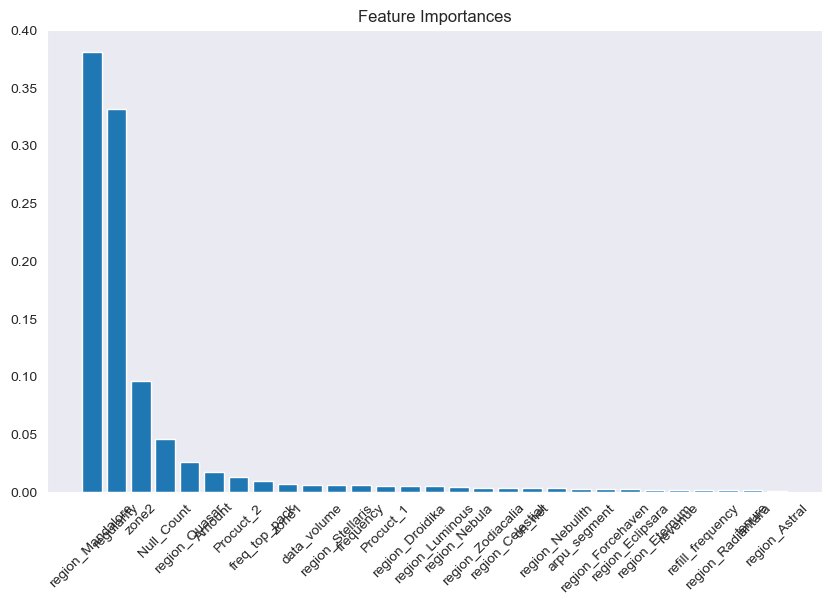

In [72]:
y_pred = model_xgb.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)
print('___________________________')
f1 = f1_score(y_test, y_pred)
print("F1 Score:", f1)
importances = model_xgb.feature_importances_
indices = np.argsort(importances)[::-1]
print("Feature ranking:")
for f in range(X_train.shape[1]):
    print(f"{X_train.columns[indices[f]]}: {importances[indices[f]]}")
plt.figure(figsize=(10, 6))
plt.bar(range(X_train.shape[1]), importances[indices], align="center")
plt.xticks(range(X_train.shape[1]), X_train.columns[indices], rotation=45)
plt.title("Feature Importances")
plt.show()

In [73]:
xgb_accuracy = cross_val_score(model_xgb, X_train, y_train, cv=5, scoring='accuracy')
xgb_f1_score = cross_val_score(model_xgb, X_train, y_train, cv=5, scoring='f1')

print("XGBoost Cross-Validation Results:")
print("Accuracy:", xgb_accuracy.mean())
print("F1 Score:", xgb_f1_score.mean())
print('________________________________________________________')

precision_xgb = precision_score(y_test, y_pred)
recall_xgb = recall_score(y_test, y_pred)
f1_xgb = f1_score(y_test, y_pred)
auc_roc_xgb = roc_auc_score(y_test, model_xgb.predict_proba(X_test)[:, 1])
print("XGBoost Metrics:")
print(f"Precision: {precision_xgb:.4f}")
print(f"Recall: {recall_xgb:.4f}")
print(f"F1 Score: {f1_xgb:.4f}")
print(f"AUC-ROC: {auc_roc_xgb:.4f}\n")
print('________________________________________________________')

XGBoost Cross-Validation Results:
Accuracy: 0.8905102389159554
F1 Score: 0.8970688069102979
________________________________________________________
XGBoost Metrics:
Precision: 0.8465
Recall: 0.9559
F1 Score: 0.8979
AUC-ROC: 0.9470

________________________________________________________


Now I want to test the model on the whole data set without class balancing to see how it performs

In [65]:
X = pd.get_dummies(raw_df.drop(columns='Target'))
y = raw_df['Target']

In [74]:
X = scaled_features
y = targets

In [81]:
dmatrix = xgb.DMatrix(data=X, label=y)
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
auc_roc_scorer = make_scorer(roc_auc_score, greater_is_better=True)
xgb_accuracy = cross_val_score(model_xgb, X, y, cv=kfold, scoring='accuracy')
xgb_f1_score = cross_val_score(model_xgb, X, y, cv=kfold, scoring='f1')
xgb_auc_scores = cross_val_score(model_xgb, X, y, cv=kfold, scoring=auc_roc_scorer)
for fold, (acc, auc_roc) in enumerate(zip(xgb_accuracy, xgb_auc_scores,xgb_f1_score), 1):
    print(f"Fold {fold}: Accuracy = {acc}, AUC-ROC = {auc_roc}")

score_list = [xgb_accuracy, xgb_auc_scores,xgb_f1_score]
colours = ['red','blue','green']
print('Model Results across the entire dataset: ')
for score,colour in score_list,colours:
    # Plot the results
    plt.figure(figsize=(10, 6))
    plt.bar(range(1, len(score) + 1), score, color=str(colour))
    plt.xlabel('Fold')
    plt.ylabel(str(score))
    plt.title(f'{score} Across Folds')
    plt.show()

ValueError: DataFrame.dtypes for data must be int, float, bool or category. When categorical type is supplied, The experimental DMatrix parameter`enable_categorical` must be set to `True`.  Invalid columns:region: object

In [75]:
final_pred = model_xgb.predict(scaled_test)
final_pred
data = list(zip(test_df.index, final_pred))

result_df = pd.DataFrame(data, columns=['ID', 'Predictions'])
print(result_df)
print(result_df['Predictions'].value_counts())
result_df.to_csv('Submission4.2Final.csv',index=False)

                     ID  Predictions
0       ID_LZ8K373W7EWV            0
1       ID_04KNWHGV5783            0
2       ID_CXS07G6VLB2U            0
3       ID_N3NFJJVHS25K            0
4       ID_R36J4ROT93E9            1
...                 ...          ...
380122  ID_MGZSA4ICBD9O            0
380123  ID_XGDT520DFBLP            0
380124  ID_9RDB792PB5Q4            0
380125  ID_KDTJHH8L8Z13            0
380126  ID_2F6Y446GS8T3            1

[380127 rows x 2 columns]
0    261026
1    119101
Name: Predictions, dtype: int64


Testing Best Model on Log Transformed data

In [53]:
scaled_features = np.log(raw_df.drop(columns=['region','Target','Null_Count','tenure'])+1)
scaled_features = pd.concat([scaled_features, raw_df[['region', 'Target', 'Null_Count', 'tenure']]], axis=1)
scaled_features
features = pd.get_dummies(scaled_features.drop(columns='Target'))
targets = raw_df['Target']

rus = RandomUnderSampler(random_state=42)
X_resampled, y_resampled  = rus.fit_resample(features,targets)
print(y_resampled.value_counts())
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled , test_size=0.2, random_state=0)

0    282515
1    282515
Name: Target, dtype: int64


In [54]:
model_xgb = xgb.XGBClassifier(
    learning_rate = 0.01,
    max_dephth = 3,
    n_estimators = 50,
    objective='binary:logistic',  
    eval_metric='auc',
    reg_alpha = 0.01, 
    reg_lambda = 0.01,
    random_state=0
)
model_xgb.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='auc', feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_dephth=3, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=50,
              n_jobs=None, num_parallel_tree=None, ...)

In [55]:
xgb_accuracy = cross_val_score(model_xgb, X_train, y_train, cv=5, scoring='accuracy')
xgb_f1_score = cross_val_score(model_xgb, X_train, y_train, cv=5, scoring='f1')

print("XGBoost Cross-Validation Results:")
print("Accuracy:", xgb_accuracy.mean())
print("F1 Score:", xgb_f1_score.mean())

XGBoost Cross-Validation Results:
Accuracy: 0.8851122946852238
F1 Score: 0.8905166858517021


Accuracy: 0.8857848255844822
Confusion Matrix:
[[46968  9335]
 [ 3572 53131]]
___________________________
F1 Score: 0.8916916312128155
Feature ranking:
regularity: 0.5351529717445374
region_Mandalore: 0.19077880680561066
zone2: 0.09775912016630173
Null_Count: 0.0708824098110199
Amount: 0.03798815980553627
Procuct_2: 0.02248508296906948
region_Quasar: 0.018273403868079185
zone1: 0.007366953417658806
data_volume: 0.004837729502469301
region_Zodiacalia: 0.0025008160155266523
freq_top_pack: 0.0022949189879000187
Procuct_1: 0.0022594882175326347
arpu_segment: 0.001977586420252919
refill_frequency: 0.0017985121812671423
on_net: 0.00137603422626853
region_Nebula: 0.0010108646238222718
revenue: 0.0007402250193990767
frequency: 0.0005169234937056899
region_Nebulith: 0.0
region_Radiantara: 0.0
region_Eclipsara: 0.0
region_Droidika: 0.0
region_Luminous: 0.0
region_Forcehaven: 0.0
region_Eternum: 0.0
region_Stellaris: 0.0
region_Astral: 0.0
region_Celestial: 0.0
tenure: 0.0


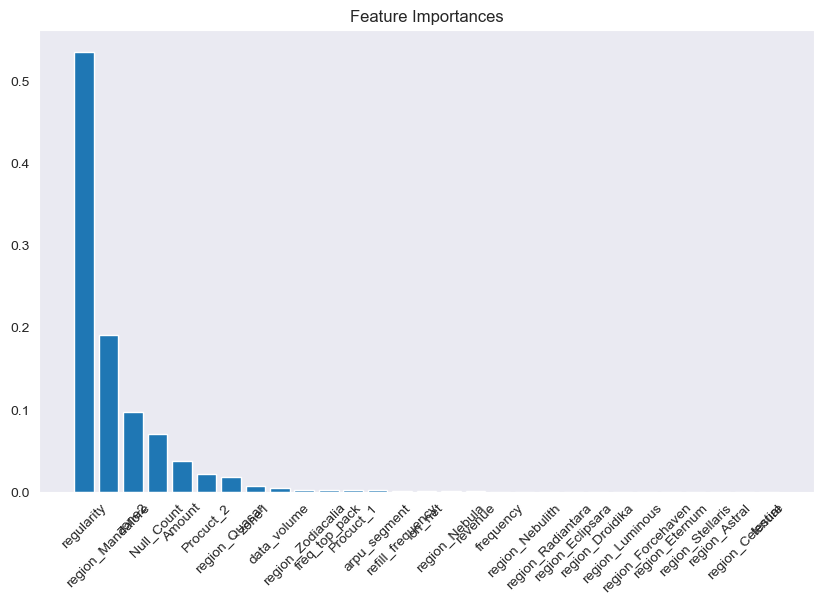

________________________________________________________
XGBoost Metrics:
Precision: 0.8506
Recall: 0.9370
F1 Score: 0.8917
AUC-ROC: 0.9432

________________________________________________________


In [56]:
y_pred = model_xgb.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)
print('___________________________')
f1 = f1_score(y_test, y_pred)
print("F1 Score:", f1)
importances = model_xgb.feature_importances_
indices = np.argsort(importances)[::-1]
print("Feature ranking:")
for f in range(X_train.shape[1]):
    print(f"{X_train.columns[indices[f]]}: {importances[indices[f]]}")
plt.figure(figsize=(10, 6))
plt.bar(range(X_train.shape[1]), importances[indices], align="center")
plt.xticks(range(X_train.shape[1]), X_train.columns[indices], rotation=45)
plt.title("Feature Importances")
plt.show()
print('________________________________________________________')
precision_xgb = precision_score(y_test, y_pred)
recall_xgb = recall_score(y_test, y_pred)
f1_xgb = f1_score(y_test, y_pred)
auc_roc_xgb = roc_auc_score(y_test, model_xgb.predict_proba(X_test)[:, 1])
print("XGBoost Metrics:")
print(f"Precision: {precision_xgb:.4f}")
print(f"Recall: {recall_xgb:.4f}")
print(f"F1 Score: {f1_xgb:.4f}")
print(f"AUC-ROC: {auc_roc_xgb:.4f}\n")
print('________________________________________________________')

In [58]:
final_pred = model_xgb.predict(scaled_test)
final_pred
data = list(zip(test_df.index, final_pred))

result_df = pd.DataFrame(data, columns=['ID', 'Predictions'])
print(result_df)
print(result_df['Predictions'].value_counts())
result_df.to_csv('Submission4.2.5LogTrans.csv',index=False)

                     ID  Predictions
0       ID_LZ8K373W7EWV            0
1       ID_04KNWHGV5783            0
2       ID_CXS07G6VLB2U            0
3       ID_N3NFJJVHS25K            0
4       ID_R36J4ROT93E9            1
...                 ...          ...
380122  ID_MGZSA4ICBD9O            0
380123  ID_XGDT520DFBLP            0
380124  ID_9RDB792PB5Q4            0
380125  ID_KDTJHH8L8Z13            0
380126  ID_2F6Y446GS8T3            1

[380127 rows x 2 columns]
0    266017
1    114110
Name: Predictions, dtype: int64


In [34]:
features = pd.get_dummies(raw_data.drop(columns=['Target','top_pack','Amount','refill_frequency','revenue']))
#features['top_pack'] = raw_data['top_pack']
targets = raw_df['Target']
rus = RandomUnderSampler(random_state=42)
X_resampled, y_resampled  = rus.fit_resample(features,targets)
print(y_resampled.value_counts())
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled , test_size=0.2, random_state=0)

0    282515
1    282515
Name: Target, dtype: int64


In [21]:
X_train

,tenure,Amount,refill_frequency,revenue,arpu_segment,frequency,data_volume,on_net,Procuct_1,Procuct_2,...,region_Forcehaven,region_Luminous,region_Mandalore,region_Nebula,region_Nebulith,region_Quasar,region_Radiantara,region_Stellaris,region_Zodiacalia,top_pack
316363,24.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,NaN
210344,24.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,NaN
193167,24.0,1965.81,7.0,2136.75,712.39,9.0,1822.0,55.0,109.0,12.0,...,0,0,1,0,0,0,0,0,0,All-net 500F=2000F;5d
560505,22.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,NaN
303163,24.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
359783,24.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,NaN
152315,24.0,NaN,NaN,NaN,NaN,NaN,165.0,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,NaN
117952,24.0,555.56,3.0,773.08,257.69,7.0,2212.0,1.0,NaN,25.0,...,0,0,0,0,0,0,0,0,0,"Data:490F=1GB,7d"
435829,24.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,NaN


In [35]:
model_xgb = xgb.XGBClassifier(
    learning_rate = 0.1,
    max_dephth = 5,
    n_estimators = 200,
    sampling_method = 'uniform',
    objective='binary:logistic',  
    eval_metric='logloss',
    grow_policy = 'depthwise', 
    tree_method = 'exact',
    updater = 'grow_histmaker',
    reg_alpha = 0.5, 
    reg_lambda = 0.01,
    verbosity = 2,
    random_state=0,
)
model_xgb.fit(X_train,y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy='depthwise',
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_dephth=5,
              max_depth=None, max_leaves=None, min_child_weight=None,
              missing=nan, monotone_constraints=None, multi_strategy=None,
              n_estimators=200, n_jobs=None, num_parallel_tree=None, ...)

Accuracy: 0.8676795922340407
Confusion Matrix:
[[45885 10418]
 [ 4535 52168]]
___________________________
F1 Score: 0.8746489617651251
Feature ranking:
regularity: 0.1823502629995346
region_Mandalore: 0.11766508966684341
region_Droidika: 0.07844554632902145
region_Eclipsara: 0.07482828944921494
region_Celestial: 0.07074904441833496
region_Luminous: 0.07001922279596329
region_Stellaris: 0.058015305548906326
region_Astral: 0.0549309216439724
region_Zodiacalia: 0.05449407920241356
region_Nebula: 0.048460640013217926
region_Nebulith: 0.04756668210029602
region_Quasar: 0.04730818793177605
region_Radiantara: 0.041375573724508286
arpu_segment: 0.017428990453481674
region_Forcehaven: 0.009469042532145977
on_net: 0.006906531285494566
region_Eternum: 0.0043142931535840034
Procuct_1: 0.004125860519707203
data_volume: 0.003918761853128672
zone1: 0.0015918136341497302
zone2: 0.0014270221581682563
tenure: 0.0014269991079345345
frequency: 0.0011924010468646884
freq_top_pack: 0.0010957407066598535
Pro

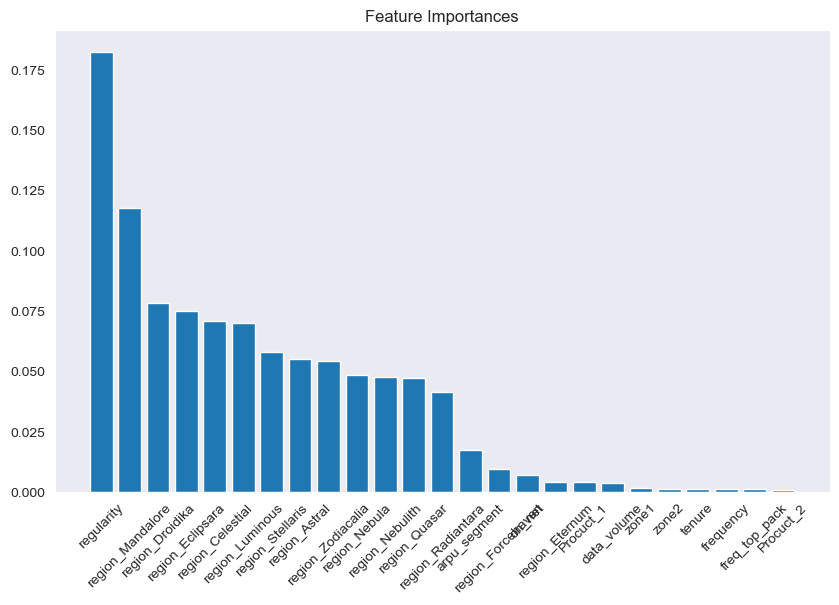

In [36]:
y_pred = model_xgb.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)
print('___________________________')
f1 = f1_score(y_test, y_pred)
print("F1 Score:", f1)
importances = model_xgb.feature_importances_
indices = np.argsort(importances)[::-1]
print("Feature ranking:")
for f in range(X_train.shape[1]):
    print(f"{X_train.columns[indices[f]]}: {importances[indices[f]]}")
plt.figure(figsize=(10, 6))
plt.bar(range(X_train.shape[1]), importances[indices], align="center")
plt.xticks(range(X_train.shape[1]), X_train.columns[indices], rotation=45)
plt.title("Feature Importances")
plt.show()

In [37]:
precision_xgb = precision_score(y_test, y_pred)
recall_xgb = recall_score(y_test, y_pred)
f1_xgb = f1_score(y_test, y_pred)
auc_roc_xgb = roc_auc_score(y_test, model_xgb.predict_proba(X_test)[:, 1])
print("XGBoost Metrics:")
print(f"Precision: {precision_xgb:.4f}")
print(f"Recall: {recall_xgb:.4f}")
print(f"F1 Score: {f1_xgb:.4f}")
print(f"AUC-ROC: {auc_roc_xgb:.4f}\n")
print('________________________________________________________')

XGBoost Metrics:
Precision: 0.8335
Recall: 0.9200
F1 Score: 0.8746
AUC-ROC: 0.9311

________________________________________________________


In [38]:
raw_test = pd.get_dummies(test_data.drop(columns=['top_pack','Amount','refill_frequency','revenue']))
raw_test

,tenure,arpu_segment,frequency,data_volume,on_net,Procuct_1,Procuct_2,zone1,zone2,regularity,...,region_Eternum,region_Forcehaven,region_Luminous,region_Mandalore,region_Nebula,region_Nebulith,region_Quasar,region_Radiantara,region_Stellaris,region_Zodiacalia
ID,,,,,,,,,,,,,,,,,,,,,
ID_LZ8K373W7EWV,24.0,670.09,17.0,10.0,247.0,17.0,70.0,NaN,NaN,59,...,0,0,0,0,0,0,0,0,0,0
ID_04KNWHGV5783,24.0,997.01,17.0,NaN,99.0,100.0,84.0,NaN,NaN,49,...,0,0,1,0,0,0,0,0,0,0
ID_CXS07G6VLB2U,24.0,526.07,8.0,436.0,47.0,113.0,5.0,NaN,NaN,13,...,0,0,0,0,0,0,0,0,0,0
ID_N3NFJJVHS25K,24.0,926.07,13.0,0.0,135.0,181.0,NaN,NaN,NaN,53,...,0,0,0,0,0,0,0,0,0,0
ID_R36J4ROT93E9,24.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ID_MGZSA4ICBD9O,24.0,1495.73,20.0,NaN,60.0,208.0,80.0,NaN,NaN,54,...,0,0,0,0,0,0,0,0,1,0
ID_XGDT520DFBLP,24.0,2371.79,41.0,7019.0,105.0,257.0,5.0,NaN,NaN,59,...,0,0,0,0,0,0,0,0,0,0
ID_9RDB792PB5Q4,24.0,14.10,1.0,0.0,1.0,1.0,NaN,NaN,NaN,43,...,0,0,0,1,0,0,0,0,0,0


In [39]:
final_pred = model_xgb.predict(raw_test)
final_pred
data = list(zip(raw_test.index, final_pred))

result_df = pd.DataFrame(data, columns=['ID', 'Predictions'])
print(result_df)
print(result_df['Predictions'].value_counts())
result_df.to_csv('Submission4.3.1RawXGB.csv',index=False)

                     ID  Predictions
0       ID_LZ8K373W7EWV            0
1       ID_04KNWHGV5783            0
2       ID_CXS07G6VLB2U            0
3       ID_N3NFJJVHS25K            0
4       ID_R36J4ROT93E9            1
...                 ...          ...
380122  ID_MGZSA4ICBD9O            0
380123  ID_XGDT520DFBLP            0
380124  ID_9RDB792PB5Q4            0
380125  ID_KDTJHH8L8Z13            0
380126  ID_2F6Y446GS8T3            1

[380127 rows x 2 columns]
0    257904
1    122223
Name: Predictions, dtype: int64


In [55]:
test_df

,region,tenure,Amount,refill_frequency,revenue,arpu_segment,frequency,data_volume,on_net,Procuct_1,Procuct_2,zone1,zone2,regularity,freq_top_pack,Null_Count
ID,,,,,,,,,,,,,,,,
ID_LZ8K373W7EWV,Droidika,24.0,2008.550,16.0,2010.26,670.09,17.0,10.0,247.0,17.0,70.0,1.0,1.0,59,11.0,2
ID_04KNWHGV5783,Luminous,24.0,2991.450,14.0,2991.45,997.01,17.0,807.5,99.0,100.0,84.0,1.0,1.0,49,12.0,3
ID_CXS07G6VLB2U,Astral,24.0,1581.200,8.0,1578.21,526.07,8.0,436.0,47.0,113.0,5.0,1.0,1.0,13,6.0,2
ID_N3NFJJVHS25K,Eclipsara,24.0,2564.100,12.0,2777.78,926.07,13.0,0.0,135.0,181.0,4.0,1.0,1.0,53,13.0,3
ID_R36J4ROT93E9,Mandalore,24.0,1391.025,7.0,1343.16,447.86,9.0,309.0,26.0,31.0,7.0,1.0,1.0,1,5.0,14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ID_MGZSA4ICBD9O,Stellaris,24.0,4273.500,19.0,4487.18,1495.73,20.0,60.0,60.0,208.0,80.0,1.0,1.0,54,20.0,3
ID_XGDT520DFBLP,Mandalore,24.0,6901.710,41.0,7115.38,2371.79,41.0,7019.0,105.0,257.0,5.0,1.0,1.0,59,33.0,3
ID_9RDB792PB5Q4,Mandalore,24.0,2008.550,9.0,42.31,14.10,1.0,0.0,1.0,1.0,7.0,1.0,2.0,43,6.0,7


In [59]:

train_data = lgb.Dataset(X_train, label=y_train)
params = {
    'objective': 'binary',
    'metric': 'binary_error',
    'boosting_type': 'gbdt',
    'num_leaves': 50,
    'learning_rate': 0.01,
    'feature_fraction': 0.9
}

# Train the model
num_round = 100
model_lgb = lgb.train(params, train_data, num_round)

# Make predictions on the test set
y_pred = model_lgb.predict(X_test, num_iteration=model_lgb.best_iteration)

# Convert probability predictions to binary predictions
y_pred = np.round(y_pred)

[LightGBM] [Info] Number of positive: 225812, number of negative: 226212
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015735 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2457
[LightGBM] [Info] Number of data points in the train set: 452024, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499558 -> initscore=-0.001770
[LightGBM] [Info] Start training from score -0.001770


Accuracy: 0.8882714192166787
Confusion Matrix:
[[46567  9736]
 [ 2890 53813]]
___________________________
F1 Score: 0.895003825300203


<Figure size 1000x600 with 0 Axes>

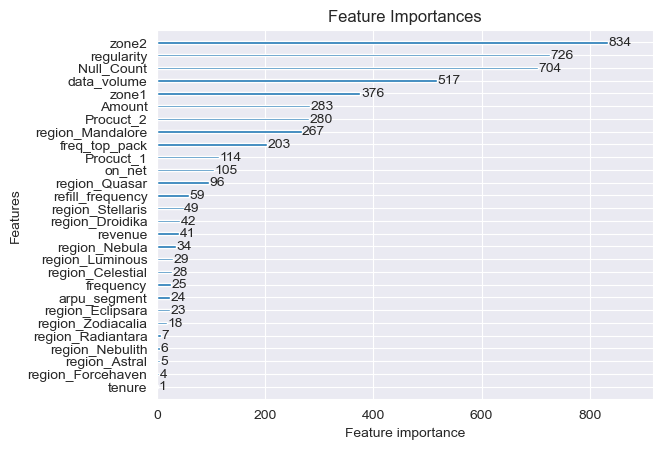

In [60]:
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)
print('___________________________')
f1 = f1_score(y_test, y_pred)
print("F1 Score:", f1)
plt.figure(figsize=(10, 6))
lgb.plot_importance(model_lgb)  # Adjust max_num_features as needed
plt.title("Feature Importances")
plt.show()

In [61]:
y_pred = model_lgb.predict(X_test, num_iteration=model_lgb.best_iteration)
y_pred_binary = np.round(y_pred)

accuracy = accuracy_score(y_test, y_pred_binary)
precision_lgb = precision_score(y_test, y_pred_binary)
recall_lgb = recall_score(y_test, y_pred_binary)
f1_lgb = f1_score(y_test, y_pred_binary)
auc_roc_lgb = roc_auc_score(y_test, y_pred)

print("LGB Metrics:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision_lgb:.4f}")
print(f"Recall: {recall_lgb:.4f}")
print(f"F1 Score: {f1_lgb:.4f}")
print(f"AUC-ROC: {auc_roc_lgb:.4f}\n")

LGB Metrics:
Accuracy: 0.8883
Precision: 0.8468
Recall: 0.9490
F1 Score: 0.8950
AUC-ROC: 0.9444



In [63]:
final_pred = model_lgb.predict(test_df)
final_pred = np.round(final_pred).astype(int)
data = list(zip(test_df.index, final_pred))

result_df = pd.DataFrame(data, columns=['ID', 'Predictions'])
print(result_df)
print(result_df['Predictions'].value_counts())
result_df.to_csv('Submission4.3.3LGB.csv',index=False)

                     ID  Predictions
0       ID_LZ8K373W7EWV            0
1       ID_04KNWHGV5783            0
2       ID_CXS07G6VLB2U            0
3       ID_N3NFJJVHS25K            0
4       ID_R36J4ROT93E9            1
...                 ...          ...
380122  ID_MGZSA4ICBD9O            0
380123  ID_XGDT520DFBLP            0
380124  ID_9RDB792PB5Q4            0
380125  ID_KDTJHH8L8Z13            0
380126  ID_2F6Y446GS8T3            1

[380127 rows x 2 columns]
0    263366
1    116761
Name: Predictions, dtype: int64


The 4th round of submissions all average around 0.67 - 0.68. Thus what my plan is to use ensemble techniques to get the best our of the best of all worlds

initial plan:
- build 2 basic models using logistic regression & random forest on the log transformed and feature engineered data
- build 1 XGB & 1 LightGB model on the original messy data
- build 1 RF model & 1 XGB model on the log transformed data
- Use XGB & CAT boosted models to use the 6 predictions + "Top_Pack" category to make final predictions (once with original data & then with imputing of the missing top pack values)

#### Before moving onto the final ensemble step I will be hyperparameter tuning the XGB & CATboosted models

ensembleming techniques that I will add in the next round if the score achieved is above the previous best:
- voting methods for the simple models to then feed into XGB model to make second round of voting with RF model
- building the 6 initial predictions, however using LightGB, XGB, & CATboosted models to make 3 predictions for a voting method to be applied
- using the prediction from the simple models to then build second level of boosting model
- using LightGB & XGB predictions to enhance the messy data to feed into CATboosted model 

The 6th iteration will be about feature engineering to feed into the best performing ensemble method including clustering techniques to split the data into groups and building models based on those clusters and then combining those predictions

The 6th iteration will also be about using more advanced techniques for filling the missing values

Combining LGB predictions with XGB model

Accuracy: 0.8501459709755849
Confusion Matrix:
[[1014112  211207]
 [  14748  267767]]
___________________________
F1 Score: 0.7032721418168877


<Figure size 1000x600 with 0 Axes>

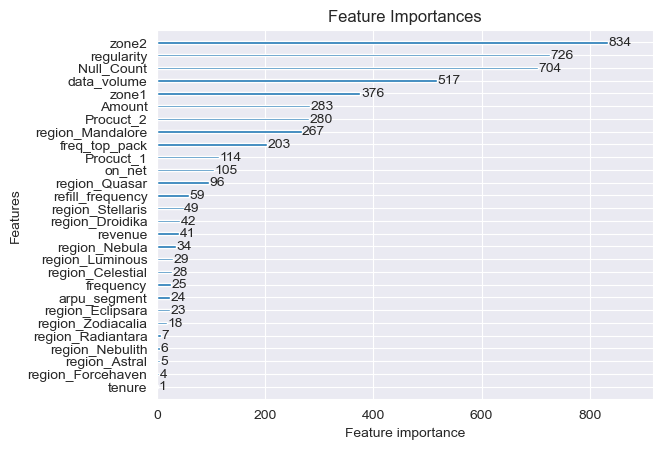

LGB Metrics:
Accuracy: 0.8501
Precision: 0.5590
Recall: 0.9478
F1 Score: 0.7033
AUC-ROC: 0.9440



In [66]:
y_pred = model_lgb.predict(features, num_iteration=model_lgb.best_iteration)
features['lgb_pred'] = y_pred
accuracy = accuracy_score(targets, np.round(y_pred))
print("Accuracy:", accuracy)

conf_matrix = confusion_matrix(targets, np.round(y_pred))
print("Confusion Matrix:")
print(conf_matrix)
print('___________________________')
f1 = f1_score(targets, np.round(y_pred))
print("F1 Score:", f1)
plt.figure(figsize=(10, 6))
lgb.plot_importance(model_lgb) 
plt.title("Feature Importances")
plt.show()
y_pred_binary = np.round(y_pred)

accuracy = accuracy_score(targets, y_pred_binary)
precision_lgb = precision_score(targets, y_pred_binary)
recall_lgb = recall_score(targets, y_pred_binary)
f1_lgb = f1_score(targets, y_pred_binary)
auc_roc_lgb = roc_auc_score(targets, y_pred)

print("LGB Metrics:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision_lgb:.4f}")
print(f"Recall: {recall_lgb:.4f}")
print(f"F1 Score: {f1_lgb:.4f}")
print(f"AUC-ROC: {auc_roc_lgb:.4f}\n")

In [70]:
test_pred = model_lgb.predict(test_df, num_iteration=model_lgb.best_iteration)
test_df['lgb_pred'] = test_pred
test_df

,tenure,Amount,refill_frequency,revenue,arpu_segment,frequency,data_volume,on_net,Procuct_1,Procuct_2,...,region_Forcehaven,region_Luminous,region_Mandalore,region_Nebula,region_Nebulith,region_Quasar,region_Radiantara,region_Stellaris,region_Zodiacalia,lgb_pred
ID,,,,,,,,,,,,,,,,,,,,,
ID_LZ8K373W7EWV,24.0,2008.550,16.0,2010.26,670.09,17.0,10.0,247.0,17.0,70.0,...,0,0,0,0,0,0,0,0,0,0.187022
ID_04KNWHGV5783,24.0,2991.450,14.0,2991.45,997.01,17.0,807.5,99.0,100.0,84.0,...,0,1,0,0,0,0,0,0,0,0.187583
ID_CXS07G6VLB2U,24.0,1581.200,8.0,1578.21,526.07,8.0,436.0,47.0,113.0,5.0,...,0,0,0,0,0,0,0,0,0,0.215040
ID_N3NFJJVHS25K,24.0,2564.100,12.0,2777.78,926.07,13.0,0.0,135.0,181.0,4.0,...,0,0,0,0,0,0,0,0,0,0.187355
ID_R36J4ROT93E9,24.0,1391.025,7.0,1343.16,447.86,9.0,309.0,26.0,31.0,7.0,...,0,0,1,0,0,0,0,0,0,0.776143
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ID_MGZSA4ICBD9O,24.0,4273.500,19.0,4487.18,1495.73,20.0,60.0,60.0,208.0,80.0,...,0,0,0,0,0,0,0,1,0,0.187355
ID_XGDT520DFBLP,24.0,6901.710,41.0,7115.38,2371.79,41.0,7019.0,105.0,257.0,5.0,...,0,0,1,0,0,0,0,0,0,0.311075
ID_9RDB792PB5Q4,24.0,2008.550,9.0,42.31,14.10,1.0,0.0,1.0,1.0,7.0,...,0,0,1,0,0,0,0,0,0,0.193729


In [67]:
features

,tenure,Amount,refill_frequency,revenue,arpu_segment,frequency,data_volume,on_net,Procuct_1,Procuct_2,...,region_Forcehaven,region_Luminous,region_Mandalore,region_Nebula,region_Nebulith,region_Quasar,region_Radiantara,region_Stellaris,region_Zodiacalia,lgb_pred
ID,,,,,,,,,,,,,,,,,,,,,
ID_YEB05X4KUGPQ,24.0,1346.15,7.0,1302.56,434.19,9.0,301.0,26.0,31.0,7.0,...,0,0,1,0,0,0,0,0,0,0.743345
ID_Z9IQ9QH52KVN,24.0,4764.96,41.0,4756.84,1585.47,41.0,2.0,626.0,24.0,3.0,...,0,0,0,1,0,0,0,0,0,0.187355
ID_YZSU7B7M35QS,24.0,5769.23,22.0,5769.23,1923.08,22.0,28121.0,0.0,31.0,1.0,...,0,0,0,0,0,0,0,0,0,0.199234
ID_QS4F5LEX29KM,24.0,1346.15,7.0,1302.56,434.19,9.0,301.0,26.0,31.0,7.0,...,0,0,1,0,0,0,0,0,0,0.700151
ID_8IYIC9PFU8U1,24.0,5341.88,58.0,5636.75,1879.06,60.0,1131.0,546.0,376.0,0.0,...,0,0,0,0,0,0,0,0,0,0.187214
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ID_D1MA2025F1U6,24.0,7179.49,17.0,6972.22,2323.93,18.0,4269.0,7.0,31.0,11.0,...,0,0,1,0,0,0,0,0,0,0.310509
ID_9H6BGU1FS1CD,24.0,854.70,2.0,854.70,285.04,2.0,2276.0,0.0,31.0,7.0,...,0,0,0,0,0,0,0,0,0,0.199932
ID_QWJPIJ065LA4,24.0,1923.08,9.0,2136.75,712.39,10.0,790.0,34.0,74.0,48.0,...,0,1,0,0,0,0,0,0,0,0.188489


In [68]:
rus = RandomUnderSampler(random_state=42)
X_resampled, y_resampled  = rus.fit_resample(features,targets)
print(y_resampled.value_counts())
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled , test_size=0.3, random_state=0)

0    282515
1    282515
Name: Target, dtype: int64


Accuracy: 0.890589880183353
Confusion Matrix:
[[69631 14887]
 [ 3659 81332]]
___________________________
F1 Score: 0.8976546548203742
Feature ranking:
lgb_pred: 0.8651389479637146
region_Mandalore: 0.010262795723974705
region_Nebula: 0.009207391180098057
region_Luminous: 0.0073572322726249695
data_volume: 0.006674015894532204
region_Quasar: 0.006332637742161751
freq_top_pack: 0.005544059909880161
Procuct_2: 0.0054857730865478516
region_Celestial: 0.005485359579324722
region_Nebulith: 0.005368961952626705
region_Radiantara: 0.005279474891722202
zone2: 0.004714519716799259
arpu_segment: 0.004656506702303886
region_Droidika: 0.004582345951348543
Null_Count: 0.004326642490923405
region_Zodiacalia: 0.00425356300547719
regularity: 0.004196980036795139
region_Stellaris: 0.004186253063380718
revenue: 0.0038120916578918695
zone1: 0.0036844471469521523
region_Eclipsara: 0.0034112813882529736
Amount: 0.003381278133019805
region_Forcehaven: 0.0033643017522990704
Procuct_1: 0.0033136550337076187
re

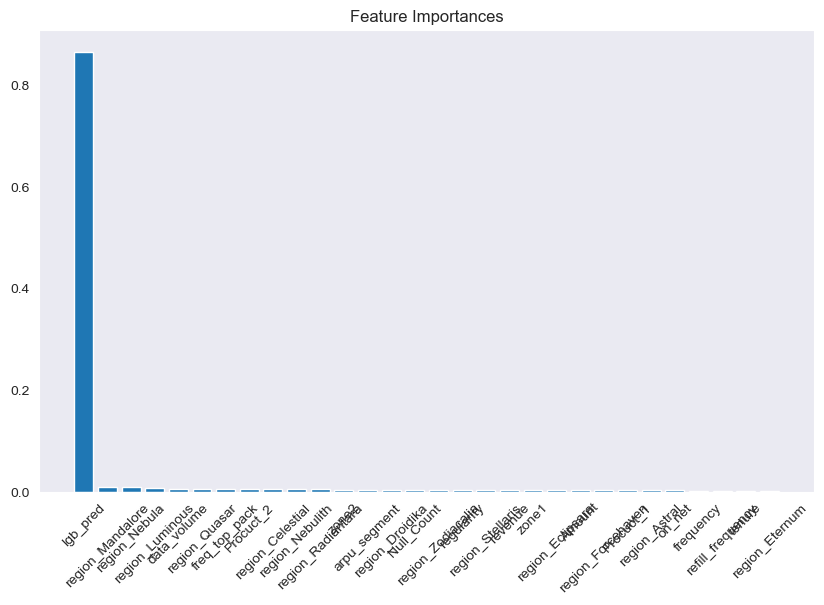

XGBoost Metrics:
Precision: 0.8453
Recall: 0.9569
F1 Score: 0.8977
AUC-ROC: 0.9463

________________________________________________________


In [71]:
model_xgb = xgb.XGBClassifier(
    learning_rate = 0.1,
    max_dephth = 5,
    n_estimators = 200,
    sampling_method = 'uniform',
    objective='binary:logistic',  
    eval_metric='logloss',
    grow_policy = 'depthwise', 
    tree_method = 'exact',
    updater = 'grow_histmaker',
    reg_alpha = 0.5, 
    reg_lambda = 0.01,
    verbosity = 2,
    random_state=0,
)
model_xgb.fit(X_train,y_train)
y_pred = model_xgb.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)
print('___________________________')
f1 = f1_score(y_test, y_pred)
print("F1 Score:", f1)
importances = model_xgb.feature_importances_
indices = np.argsort(importances)[::-1]
print("Feature ranking:")
for f in range(X_train.shape[1]):
    print(f"{X_train.columns[indices[f]]}: {importances[indices[f]]}")
plt.figure(figsize=(10, 6))
plt.bar(range(X_train.shape[1]), importances[indices], align="center")
plt.xticks(range(X_train.shape[1]), X_train.columns[indices], rotation=45)
plt.title("Feature Importances")
plt.show()
precision_xgb = precision_score(y_test, y_pred)
recall_xgb = recall_score(y_test, y_pred)
f1_xgb = f1_score(y_test, y_pred)
auc_roc_xgb = roc_auc_score(y_test, model_xgb.predict_proba(X_test)[:, 1])
print("XGBoost Metrics:")
print(f"Precision: {precision_xgb:.4f}")
print(f"Recall: {recall_xgb:.4f}")
print(f"F1 Score: {f1_xgb:.4f}")
print(f"AUC-ROC: {auc_roc_xgb:.4f}\n")
print('________________________________________________________')

In [73]:
final_pred = model_xgb.predict(test_df)
final_pred
data = list(zip(raw_test.index, final_pred))

result_df = pd.DataFrame(data, columns=['ID', 'Predictions'])
print(result_df)
print(result_df['Predictions'].value_counts())
result_df.to_csv('Submission5.0.1EnsXGB.csv',index=False)

                     ID  Predictions
0       ID_LZ8K373W7EWV            0
1       ID_04KNWHGV5783            0
2       ID_CXS07G6VLB2U            0
3       ID_N3NFJJVHS25K            0
4       ID_R36J4ROT93E9            1
...                 ...          ...
380122  ID_MGZSA4ICBD9O            0
380123  ID_XGDT520DFBLP            0
380124  ID_9RDB792PB5Q4            0
380125  ID_KDTJHH8L8Z13            0
380126  ID_2F6Y446GS8T3            1

[380127 rows x 2 columns]
0    262137
1    117990
Name: Predictions, dtype: int64


Training using the entire dataset

In [75]:
features.drop(columns='lgb_pred',inplace=True)

X_train, X_test, y_train, y_test = train_test_split(features, targets , test_size=0.3, random_state=0)

In [77]:
train_data = lgb.Dataset(X_train, label=y_train)
num_round = 100
model_lgb = lgb.train(params, train_data, num_round)
y_pred = model_lgb.predict(X_test, num_iteration=model_lgb.best_iteration)

[LightGBM] [Info] Number of positive: 197545, number of negative: 857938
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.069199 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2508
[LightGBM] [Info] Number of data points in the train set: 1055483, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.187161 -> initscore=-1.468565
[LightGBM] [Info] Start training from score -1.468565


Accuracy: 0.8762907565142998
Confusion Matrix:
[[355842  11539]
 [ 44421  40549]]
___________________________
F1 Score: 0.5917057012359731


<Figure size 1000x600 with 0 Axes>

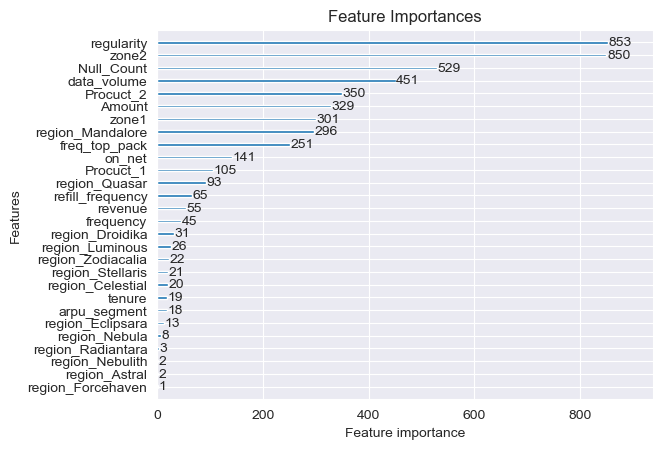

LGB Metrics:
Accuracy: 0.8763
Precision: 0.7785
Recall: 0.4772
F1 Score: 0.5917
AUC-ROC: 0.9447



In [79]:
accuracy = accuracy_score(y_test, np.round(y_pred))
print("Accuracy:", accuracy)

conf_matrix = confusion_matrix(y_test, np.round(y_pred))
print("Confusion Matrix:")
print(conf_matrix)
print('___________________________')
f1 = f1_score(y_test, np.round(y_pred))
print("F1 Score:", f1)
plt.figure(figsize=(10, 6))
lgb.plot_importance(model_lgb) 
plt.title("Feature Importances")
plt.show()
y_pred = model_lgb.predict(X_test, num_iteration=model_lgb.best_iteration)
y_pred_binary = np.round(y_pred)

accuracy = accuracy_score(y_test, y_pred_binary)
precision_lgb = precision_score(y_test, y_pred_binary)
recall_lgb = recall_score(y_test, y_pred_binary)
f1_lgb = f1_score(y_test, y_pred_binary)
auc_roc_lgb = roc_auc_score(y_test, y_pred)

print("LGB Metrics:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision_lgb:.4f}")
print(f"Recall: {recall_lgb:.4f}")
print(f"F1 Score: {f1_lgb:.4f}")
print(f"AUC-ROC: {auc_roc_lgb:.4f}\n")

In [84]:
features

,tenure,Amount,refill_frequency,revenue,arpu_segment,frequency,data_volume,on_net,Procuct_1,Procuct_2,...,region_Forcehaven,region_Luminous,region_Mandalore,region_Nebula,region_Nebulith,region_Quasar,region_Radiantara,region_Stellaris,region_Zodiacalia,lgb_pred
ID,,,,,,,,,,,,,,,,,,,,,
ID_YEB05X4KUGPQ,24.0,1346.15,7.0,1302.56,434.19,9.0,301.0,26.0,31.0,7.0,...,0,0,1,0,0,0,0,0,0,0.460473
ID_Z9IQ9QH52KVN,24.0,4764.96,41.0,4756.84,1585.47,41.0,2.0,626.0,24.0,3.0,...,0,0,0,1,0,0,0,0,0,0.070116
ID_YZSU7B7M35QS,24.0,5769.23,22.0,5769.23,1923.08,22.0,28121.0,0.0,31.0,1.0,...,0,0,0,0,0,0,0,0,0,0.073151
ID_QS4F5LEX29KM,24.0,1346.15,7.0,1302.56,434.19,9.0,301.0,26.0,31.0,7.0,...,0,0,1,0,0,0,0,0,0,0.380339
ID_8IYIC9PFU8U1,24.0,5341.88,58.0,5636.75,1879.06,60.0,1131.0,546.0,376.0,0.0,...,0,0,0,0,0,0,0,0,0,0.070038
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ID_D1MA2025F1U6,24.0,7179.49,17.0,6972.22,2323.93,18.0,4269.0,7.0,31.0,11.0,...,0,0,1,0,0,0,0,0,0,0.089632
ID_9H6BGU1FS1CD,24.0,854.70,2.0,854.70,285.04,2.0,2276.0,0.0,31.0,7.0,...,0,0,0,0,0,0,0,0,0,0.073515
ID_QWJPIJ065LA4,24.0,1923.08,9.0,2136.75,712.39,10.0,790.0,34.0,74.0,48.0,...,0,1,0,0,0,0,0,0,0,0.070605


In [85]:
features.drop(columns='lgb_pred',inplace=True)
y_pred = model_lgb.predict(features, num_iteration=model_lgb.best_iteration)
features['lgb_pred'] = y_pred
X_train, X_test, y_train, y_test = train_test_split(features, targets , test_size=0.3, random_state=0)

Accuracy: 0.8897382784607528
Confusion Matrix:
[[342373  25008]
 [ 24869  60101]]
___________________________
F1 Score: 0.7067421609957725
Feature ranking:
lgb_pred: 0.8874303698539734
region_Mandalore: 0.00917860958725214
freq_top_pack: 0.008135429583489895
region_Luminous: 0.007137698121368885
region_Quasar: 0.006351565010845661
region_Celestial: 0.005147051066160202
region_Nebula: 0.004846225958317518
data_volume: 0.004758003633469343
Procuct_2: 0.004120821598917246
regularity: 0.004016445484012365
region_Radiantara: 0.003981763496994972
Null_Count: 0.003875579684972763
zone2: 0.0038102390244603157
region_Nebulith: 0.0036532056983560324
region_Droidika: 0.0035590119659900665
revenue: 0.003408007323741913
arpu_segment: 0.003391818143427372
region_Forcehaven: 0.0032255484256893396
region_Eclipsara: 0.003061569295823574
on_net: 0.00303268083371222
region_Zodiacalia: 0.0027188670355826616
Amount: 0.0026193091180175543
Procuct_1: 0.002613215474411845
zone1: 0.0025520354975014925
tenure: 

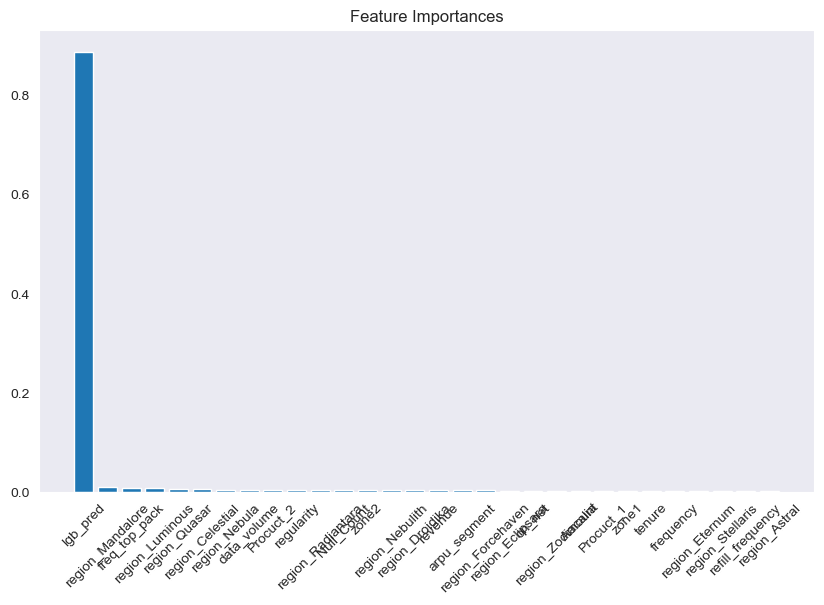

XGBoost Metrics:
Precision: 0.7062
Recall: 0.7073
F1 Score: 0.7067
AUC-ROC: 0.9470

________________________________________________________


In [86]:
model_xgb.fit(X_train,y_train)
y_pred = model_xgb.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)
print('___________________________')
f1 = f1_score(y_test, y_pred)
print("F1 Score:", f1)
importances = model_xgb.feature_importances_
indices = np.argsort(importances)[::-1]
print("Feature ranking:")
for f in range(X_train.shape[1]):
    print(f"{X_train.columns[indices[f]]}: {importances[indices[f]]}")
plt.figure(figsize=(10, 6))
plt.bar(range(X_train.shape[1]), importances[indices], align="center")
plt.xticks(range(X_train.shape[1]), X_train.columns[indices], rotation=45)
plt.title("Feature Importances")
plt.show()
precision_xgb = precision_score(y_test, y_pred)
recall_xgb = recall_score(y_test, y_pred)
f1_xgb = f1_score(y_test, y_pred)
auc_roc_xgb = roc_auc_score(y_test, model_xgb.predict_proba(X_test)[:, 1])
print("XGBoost Metrics:")
print(f"Precision: {precision_xgb:.4f}")
print(f"Recall: {recall_xgb:.4f}")
print(f"F1 Score: {f1_xgb:.4f}")
print(f"AUC-ROC: {auc_roc_xgb:.4f}\n")
print('________________________________________________________')

In [89]:
test_df.drop(columns='lgb_pred',inplace=True)
test_pred = model_lgb.predict(test_df, num_iteration=model_lgb.best_iteration)
test_df['lgb_pred'] = test_pred
test_df

,tenure,Amount,refill_frequency,revenue,arpu_segment,frequency,data_volume,on_net,Procuct_1,Procuct_2,...,region_Forcehaven,region_Luminous,region_Mandalore,region_Nebula,region_Nebulith,region_Quasar,region_Radiantara,region_Stellaris,region_Zodiacalia,lgb_pred
ID,,,,,,,,,,,,,,,,,,,,,
ID_LZ8K373W7EWV,24.0,2008.550,16.0,2010.26,670.09,17.0,10.0,247.0,17.0,70.0,...,0,0,0,0,0,0,0,0,0,0.070038
ID_04KNWHGV5783,24.0,2991.450,14.0,2991.45,997.01,17.0,807.5,99.0,100.0,84.0,...,0,1,0,0,0,0,0,0,0,0.070116
ID_CXS07G6VLB2U,24.0,1581.200,8.0,1578.21,526.07,8.0,436.0,47.0,113.0,5.0,...,0,0,0,0,0,0,0,0,0,0.078545
ID_N3NFJJVHS25K,24.0,2564.100,12.0,2777.78,926.07,13.0,0.0,135.0,181.0,4.0,...,0,0,0,0,0,0,0,0,0,0.070116
ID_R36J4ROT93E9,24.0,1391.025,7.0,1343.16,447.86,9.0,309.0,26.0,31.0,7.0,...,0,0,1,0,0,0,0,0,0,0.566690
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ID_MGZSA4ICBD9O,24.0,4273.500,19.0,4487.18,1495.73,20.0,60.0,60.0,208.0,80.0,...,0,0,0,0,0,0,0,1,0,0.070116
ID_XGDT520DFBLP,24.0,6901.710,41.0,7115.38,2371.79,41.0,7019.0,105.0,257.0,5.0,...,0,0,1,0,0,0,0,0,0,0.100797
ID_9RDB792PB5Q4,24.0,2008.550,9.0,42.31,14.10,1.0,0.0,1.0,1.0,7.0,...,0,0,1,0,0,0,0,0,0,0.071876


In [90]:
final_pred = model_xgb.predict(test_df)
final_pred
data = list(zip(raw_test.index, final_pred))

result_df = pd.DataFrame(data, columns=['ID', 'Predictions'])
print(result_df)
print(result_df['Predictions'].value_counts())
result_df.to_csv('Submission5.0.2EnsXGB.csv',index=False)

                     ID  Predictions
0       ID_LZ8K373W7EWV            0
1       ID_04KNWHGV5783            0
2       ID_CXS07G6VLB2U            0
3       ID_N3NFJJVHS25K            0
4       ID_R36J4ROT93E9            1
...                 ...          ...
380122  ID_MGZSA4ICBD9O            0
380123  ID_XGDT520DFBLP            0
380124  ID_9RDB792PB5Q4            0
380125  ID_KDTJHH8L8Z13            0
380126  ID_2F6Y446GS8T3            1

[380127 rows x 2 columns]
0    312760
1     67367
Name: Predictions, dtype: int64


In [ ]:
features = pd.get_dummies(raw_data.drop(columns=['Target','top_pack','Amount','refill_frequency','revenue']))
#features['top_pack'] = raw_data['top_pack']
targets = raw_data['Target']
rus = RandomUnderSampler(random_state=42)
X_resampled, y_resampled  = rus.fit_resample(features,targets)
print(y_resampled.value_counts())
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled , test_size=0.3, random_state=0)